# Compas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve, roc_curve, auc
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

In [2]:
pd.__version__

'1.3.4'

In [3]:
df = pd.read_csv("compas-scores-two-years.csv")

In [4]:
df.head()

id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custody  out_custody  priors_count.1  \
0           Low        2013-08-14  2014-07-07   2014-07-14               0   
1           Low        2013-01-27  2013-01-26   2013-02-05               0   
2           Low        2013-04-14  2013-06-16   2013-06-16               4   
3        Medium        2013-01-13         NaN          NaN               1   
4           Low        2013-03-26         NaN          NaN               2   

  start   end event two_year_recid  
0     0   327     0              0  
1     9   159     1              1  
2     0    63     0              1  
3     0  1174     0              0  
4     0  1102     0              0  

[5 rows x 53 columns]

In [7]:
print(df.shape)
rows, cols = df.shape

(7214, 53)


# Data ananlysis

## Demographic distributions

In [8]:
races = {}
for r in df["race"].unique():
    races[r] = df[df.race == r].shape[0]

print(races)

{'Other': 377, 'African-American': 3696, 'Caucasian': 2454, 'Hispanic': 637, 'Native American': 18, 'Asian': 32}


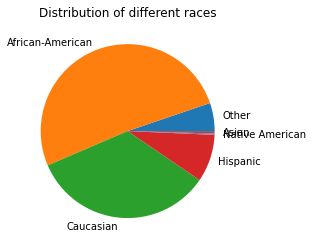

In [9]:
plt.pie(races.values(), labels=races.keys())
plt.title("Distribution of different races")
plt.show()

In [10]:
genders = {}
for s in df["sex"].unique():
    genders[s] = df[df.sex == s].shape[0]

print(genders)

{'Male': 5819, 'Female': 1395}


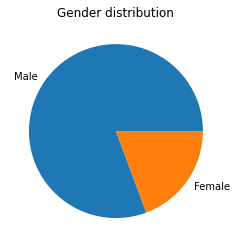

In [11]:
plt.pie(genders.values(), labels=genders.keys())
plt.title("Gender distribution")
plt.show()

In [12]:
ages = {}

for a in df["age_cat"].unique():
    ages[a] = df[df.age_cat == a].shape[0]

print(ages)

{'Greater than 45': 1576, '25 - 45': 4109, 'Less than 25': 1529}


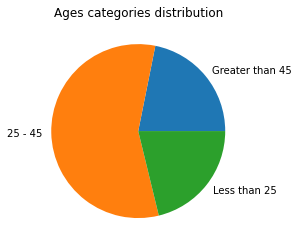

In [13]:
plt.pie(ages.values(), labels=ages.keys())
plt.title("Ages categories distribution")
plt.show()

## Racial bias in Compas classifier

In [14]:
scores = {}

for s in df["v_score_text"].unique():
    scores[s] = df[df.v_score_text == s].shape[0]

print(scores)

{'Low': 4761, 'Medium': 1739, 'High': 714}


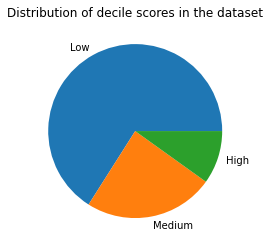

In [15]:
plt.pie(scores.values(), labels=scores.keys())
plt.title("Distribution of decile scores in the dataset")
plt.show()

In [16]:
blacks = df[df.race == "African-American"].copy()

In [17]:
whites = df[df.race == "Caucasian"].copy()

In [18]:
females = df[df.sex == "Female"].copy()

In [19]:
males = df[df.sex == "Male"].copy()

Distribution of high decile scores over races

In [20]:
h_whites = whites.loc[whites['v_score_text'] == "High"].shape[0]

In [21]:
h_blacks = blacks.loc[blacks['v_score_text'] == "High"].shape[0]

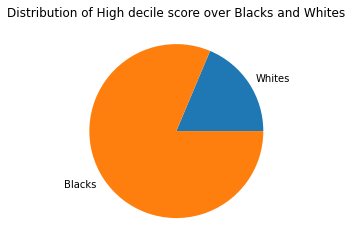

In [22]:
plt.pie([h_whites, h_blacks], labels=['Whites', 'Blacks'])
plt.title("Distribution of High decile score over Blacks and Whites")
plt.show()

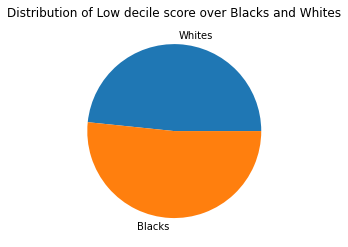

In [23]:
plt.pie([whites.loc[whites['v_score_text'] == "Low"].shape[0], blacks.loc[blacks['v_score_text'] == "Low"].shape[0]], labels=['Whites', 'Blacks'])
plt.title("Distribution of Low decile score over Blacks and Whites")
plt.show()

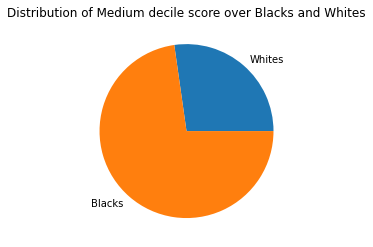

In [24]:
plt.pie([whites.loc[whites['v_score_text'] == "Medium"].shape[0], blacks.loc[blacks['v_score_text'] == "Medium"].shape[0]], labels=['Whites', 'Blacks'])
plt.title("Distribution of Medium decile score over Blacks and Whites")
plt.show()

In [25]:
w_scores = whites.groupby("v_score_text").apply(lambda group: len(group)).reset_index(name='nb_white')

In [26]:
w_scores

v_score_text  nb_white
0         High       122
1          Low      1911
2       Medium       421

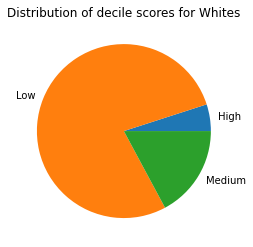

In [27]:
plt.pie(w_scores["nb_white"].values, labels=w_scores["v_score_text"].values)
plt.title("Distribution of decile scores for Whites")
plt.show()

In [28]:
b_scores = blacks.groupby("v_score_text").apply(lambda group: len(group)).reset_index(name='nb_black')

In [29]:
b_scores

v_score_text  nb_black
0         High       532
1          Low      2040
2       Medium      1124

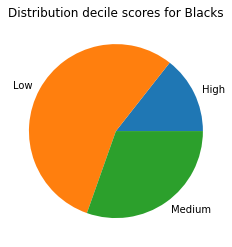

In [30]:
plt.pie(b_scores["nb_black"].values, labels=b_scores["v_score_text"].values)
plt.title("Distribution decile scores for Blacks")
plt.show()

Compare the distribution of decile scores between whites and blacks

In [31]:
text_scores = w_scores.merge(b_scores, how='inner', on='v_score_text')

In [32]:
text_scores

v_score_text  nb_white  nb_black
0         High       122       532
1          Low      1911      2040
2       Medium       421      1124

Text(0.5, 1.0, 'Comparison of decile scores between whites and blacks')

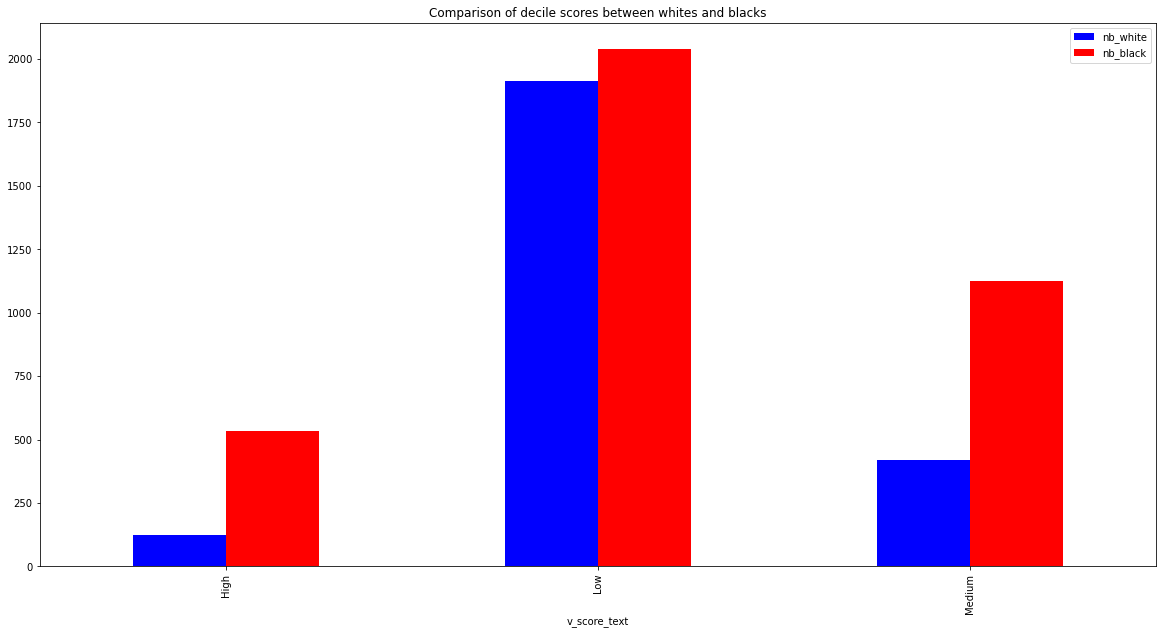

In [33]:
colors = ['blue','red']
text_scores.plot(x="v_score_text", y=["nb_white", "nb_black"], kind="bar", color=colors, figsize=(20, 10), title="")
plt.title("Comparison of decile scores between whites and blacks")

We will use percentages for the distribution of scores since the number of blacks in the data set is higher than whites

In [34]:
w_pscores = whites.groupby("v_score_text").apply(lambda group: 100*len(group)/whites.shape[0]).reset_index(name='percentage_white')

In [35]:
w_pscores

v_score_text  percentage_white
0         High          4.971475
1          Low         77.872861
2       Medium         17.155664

In [36]:
b_pscores = blacks.groupby("v_score_text").apply(lambda group: 100*len(group)/blacks.shape[0]).reset_index(name='percentage_black')

In [37]:
b_pscores

v_score_text  percentage_black
0         High         14.393939
1          Low         55.194805
2       Medium         30.411255

In [38]:
text_pscores = w_pscores.merge(b_pscores, how='inner', on='v_score_text')

In [39]:
text_pscores

v_score_text  percentage_white  percentage_black
0         High          4.971475         14.393939
1          Low         77.872861         55.194805
2       Medium         17.155664         30.411255

<AxesSubplot:title={'center':'Comparison of percentages of decile scores between whites and blacks'}, xlabel='v_score_text'>

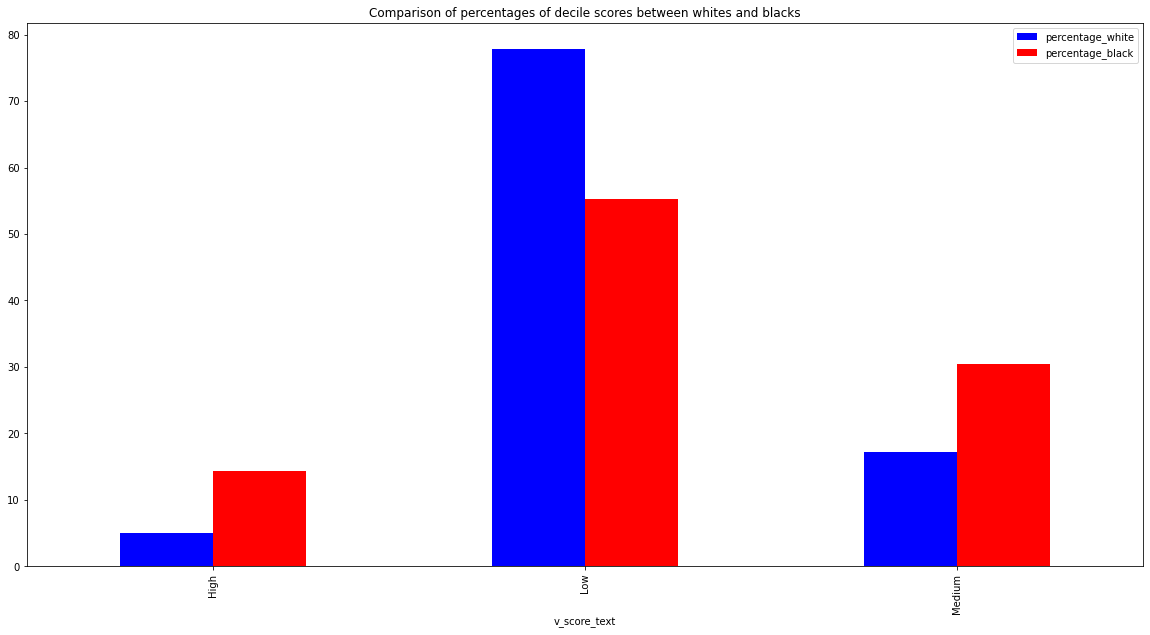

In [40]:
colors = ['blue','red']
text_pscores.plot(x="v_score_text", y=["percentage_white", "percentage_black"], kind="bar", color=colors, figsize=(20, 10), title="Comparison of percentages of decile scores between whites and blacks")

We will now check the recidivism distribution between whites and blacks 

In [42]:
b_recides = blacks.groupby("two_year_recid").apply(lambda group: len(group)).reset_index(name='recid_blacks')

In [43]:
b_recides

two_year_recid  recid_blacks
0               0          1795
1               1          1901

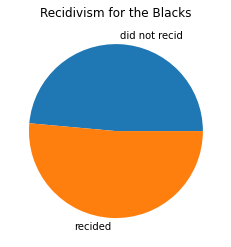

In [44]:
plt.pie(b_recides['recid_blacks'], labels=['did not recid', 'recided'])
plt.title("Recidivism for the Blacks")
plt.show()

In [45]:
w_recides = whites.groupby("two_year_recid").apply(lambda group: len(group)).reset_index(name='recid_whites')

In [46]:
w_recides

two_year_recid  recid_whites
0               0          1488
1               1           966

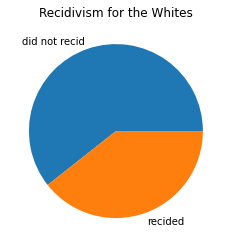

In [47]:
plt.pie(w_recides['recid_whites'], labels=['did not recid', 'recided'])
plt.title("Recidivism for the Whites")
plt.show()

In [48]:
recides = w_recides.merge(b_recides, how='inner', on='two_year_recid')

In [49]:
recides

two_year_recid  recid_whites  recid_blacks
0               0          1488          1795
1               1           966          1901

<AxesSubplot:title={'center':'Comparison of two year recidivism between Blacks and Whites'}, xlabel='two_year_recid'>

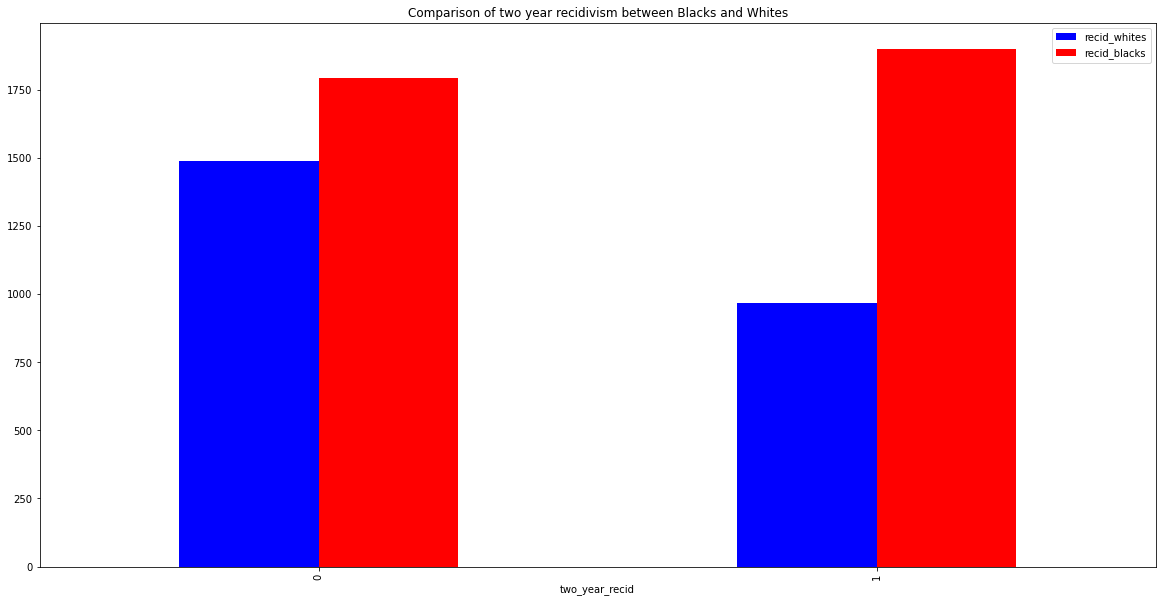

In [50]:
colors = ['blue','red']
recides.plot(x="two_year_recid", y=["recid_whites", "recid_blacks"], kind="bar", color=colors, figsize=(20, 10), title="Comparison of two year recidivism between Blacks and Whites")

## Compas prediction accuracy

We will compute the accuracy using just the hight scores first

In [51]:
preds = []
preds = (df["v_score_text"] == "High")
preds = preds.astype(int)

In [52]:
roc = roc_auc_score(df["two_year_recid"] , preds)
print(roc)

0.5557789513007625


We will use High and Medium scores for computing the accuracy

In [53]:
preds_hm = ((df["v_score_text"] == "High") | (df["v_score_text"] == "Medium"))
preds_hm = preds_hm.astype(int)

In [54]:
roc = roc_auc_score(df["two_year_recid"] , preds_hm)
print(roc)

0.6146605407928599


In [55]:
rec = recall_score(df["two_year_recid"] , preds_hm)
print(rec)

0.46601045832051674


In [56]:
prec = precision_score(df["two_year_recid"] , preds_hm)
print(prec)

0.6176110884631064


In [57]:
fpr_compas, tpr_compas, thresholds =roc_curve(df["two_year_recid"], preds_hm)
roc_auc_compas = auc(fpr_compas, tpr_compas)
print("True positive rate: ", tpr_compas[1])
print("False positive rate: ", fpr_compas[1])

True positive rate:  0.46601045832051674
False positive rate:  0.23668937673479687


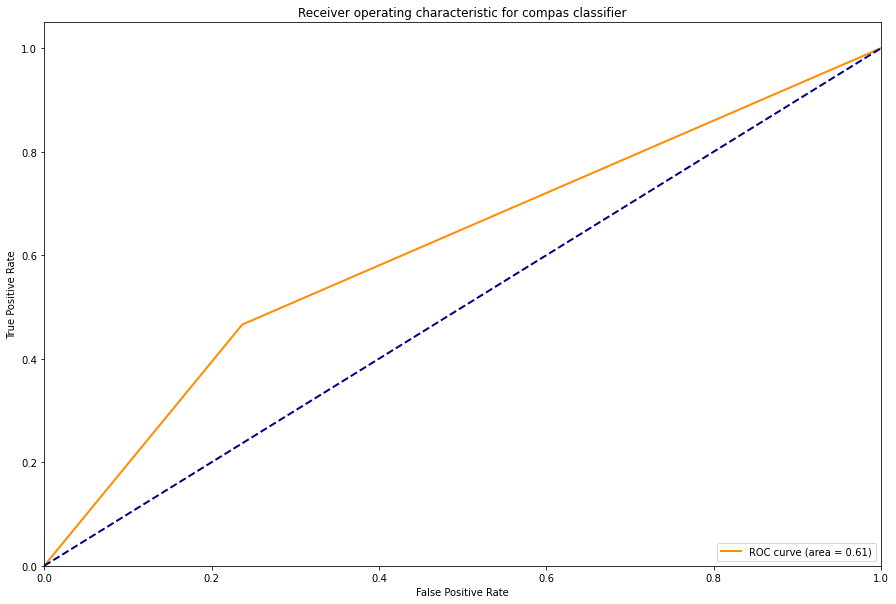

In [58]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_compas,
    tpr_compas,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_compas,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for compas classifier")
plt.legend(loc="lower right")
plt.show()

We can see from the roc curve that the model predictions are not bad

We will check for racial bias in compas classifier

In [68]:
w_preds = []
w_preds = ((whites["v_score_text"] == "High") | (whites["v_score_text"] == "Medium"))
w_preds = w_preds.astype(int)

In [69]:
roc = roc_auc_score(whites["two_year_recid"] , w_preds)
print(roc)

0.5838697154878781


In [70]:
rec = recall_score(whites["two_year_recid"] , w_preds)
print(rec)

0.32298136645962733


In [71]:
prec = precision_score(whites["two_year_recid"] , w_preds)
print(prec)

0.574585635359116


In [72]:
fpr_compas_whites, tpr_compas_whites, thresholds =roc_curve(whites["two_year_recid"], w_preds)
roc_auc_compas_whites = auc(fpr_compas_whites, tpr_compas_whites)
print("True positive rate: ", tpr_compas_whites[1])
print("False positive rate: ", fpr_compas_whites[1])

True positive rate:  0.32298136645962733
False positive rate:  0.15524193548387097


In [73]:
cm = confusion_matrix(whites["two_year_recid"] , w_preds)
positive_whites_compas = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_whites_compas = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_whites_compas)
print("Negative rate: ",negative_whites_compas)

Positive rate:  0.22127139364303178
Negative rate:  0.7787286063569682


For African-Americans:

In [74]:
b_preds = []
b_preds = ((blacks["v_score_text"] == "High") | (blacks["v_score_text"] == "Medium"))
b_preds = b_preds.astype(int)

In [75]:
roc = roc_auc_score(blacks["two_year_recid"] , b_preds)
print(roc)

0.6144086311412114


In [76]:
rec = recall_score(blacks["two_year_recid"] , b_preds)
print(rec)

0.5591793792740662


In [77]:
prec = precision_score(blacks["two_year_recid"] , b_preds)
print(prec)

0.6419082125603864


In [78]:
fpr_compas_blacks, tpr_compas_blacks, thresholds =roc_curve(blacks["two_year_recid"], b_preds)
roc_auc_compas_blacks = auc(fpr_compas_blacks, tpr_compas_blacks)
print("True positive rate: ", tpr_compas_blacks[1])
print("False positive rate: ", fpr_compas_blacks[1])

True positive rate:  0.5591793792740662
False positive rate:  0.3303621169916435


In [79]:
cm = confusion_matrix(blacks["two_year_recid"] , b_preds)
positive_blacks_compas = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_blacks_compas = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_blacks_compas)
print("Negative rate: ",negative_blacks_compas)

Positive rate:  0.44805194805194803
Negative rate:  0.551948051948052


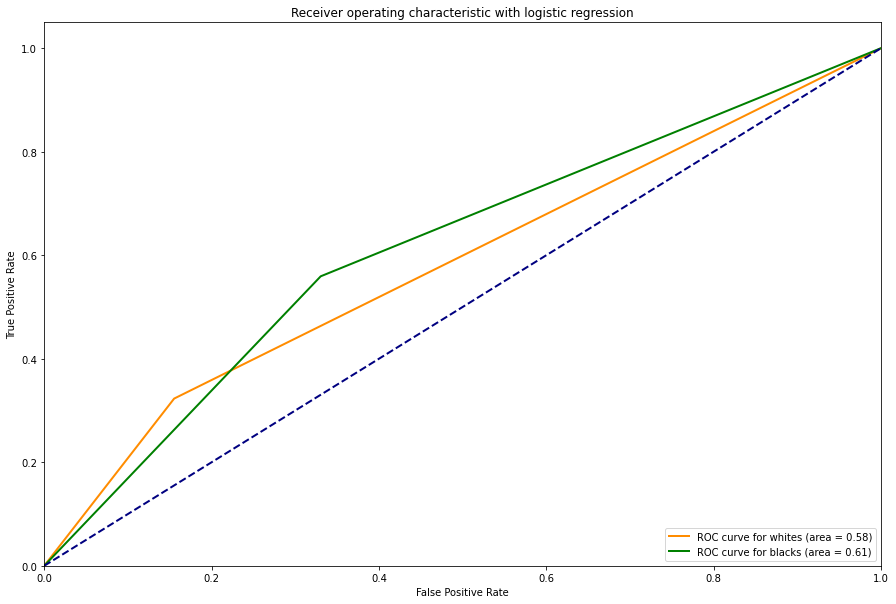

In [80]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_compas_whites,
    tpr_compas_whites,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_compas_whites,
)
plt.plot(
    fpr_compas_blacks,
    tpr_compas_blacks,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_compas_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for compas classifier")
plt.legend(loc="lower right")
plt.show()

We can see here that the true positive rate for blacks is much higher than for whites and also the false positive rate for whites is much lower than the one for blacks which suggests very high bias

In [81]:
positive_compas_diff = positive_blacks_compas - positive_whites_compas
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_compas_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.22678055440891626


In [82]:
negative_compas_diff = negative_blacks_compas - negative_whites_compas
print("The negative rate for blacks is lower than the one for whites by a ratio of: ", abs(negative_compas_diff))

The negative rate for blacks is lower than the one for whites by a ratio of:  0.2267805544089162


In [83]:
tpr_compas_diff = tpr_compas_blacks[1] - tpr_compas_whites[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_compas_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.23619801281443892


We can see that there's 22% bias in the compas classifier

We will check now for gender bias in compas

In [102]:
f_preds = []
f_preds = ((females["v_score_text"] == "High") | (females["v_score_text"] == "Medium"))
f_preds = f_preds.astype(int)

In [103]:
roc = roc_auc_score(females["two_year_recid"] , f_preds)
print(roc)

0.5687834951847525


In [104]:
rec = recall_score(females["two_year_recid"] , f_preds)
print(rec)

0.3293172690763052


In [105]:
prec = precision_score(females["two_year_recid"] , f_preds)
print(prec)

0.4880952380952381


In [106]:
fpr_compas_females, tpr_compas_females, thresholds =roc_curve(females["two_year_recid"], f_preds)
roc_auc_compas_females = auc(fpr_compas_females, tpr_compas_females)
print("True positive rate: ", tpr_compas_females[1])
print("False positive rate: ", fpr_compas_females[1])

True positive rate:  0.3293172690763052
False positive rate:  0.19175027870680045


In [107]:
cm = confusion_matrix(females["two_year_recid"] , f_preds)
positive_females_compas = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_females_compas = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_females_compas)
print("Negative rate: ",negative_females_compas)

Positive rate:  0.24086021505376345
Negative rate:  0.7591397849462366


For males:

In [108]:
m_preds = []
m_preds = ((males["v_score_text"] == "High") | (males["v_score_text"] == "Medium"))
m_preds = m_preds.astype(int)

In [109]:
roc = roc_auc_score(males["two_year_recid"] , m_preds)
print(roc)

0.620450228168334


In [110]:
rec = recall_score(males["two_year_recid"] , m_preds)
print(rec)

0.49073737740646567


In [111]:
prec = precision_score(males["two_year_recid"] , m_preds)
print(prec)

0.6381672177609825


In [112]:
fpr_compas_males, tpr_compas_males, thresholds =roc_curve(males["two_year_recid"], m_preds)
roc_auc_compas_males = auc(fpr_compas_males, tpr_compas_males)
print("True positive rate: ", tpr_compas_males[1])
print("False positive rate: ", fpr_compas_males[1])

True positive rate:  0.49073737740646567
False positive rate:  0.24983692106979777


In [113]:
cm = confusion_matrix(males["two_year_recid"] , m_preds)
positive_males_compas = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_males_compas = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_males_compas)
print("Negative rate: ",negative_males_compas)

Positive rate:  0.3638082144698402
Negative rate:  0.6361917855301599


In [114]:
positive_compas_diff = positive_females_compas - positive_males_compas
print("The positive rate for females is lower than the one for males by a ratio of: ", abs(positive_compas_diff))

The positive rate for females is lower than the one for males by a ratio of:  0.12294799941607673


In [115]:
tpr_compas_diff = tpr_compas_females[1] - tpr_compas_males[1] 
print("The positive rate for females is lower than the one for males by a ratio of: ",abs(tpr_compas_diff))

The positive rate for females is lower than the one for males by a ratio of:  0.16142010833016046


# Data Cleanning

We will drop columns that have null in all entries, we have only one column that satisfies this which is `violent_recid`

In [5]:
df.dropna(axis=1, how='all', inplace=True)

Drop columns that contain compas scores or columns that contain ground truth data

In [6]:
clean_df = df.drop(columns=['is_recid', 'is_violent_recid', 'type_of_assessment', 'v_type_of_assessment','compas_screening_date', 'v_screening_date', 'days_b_screening_arrest', 'c_days_from_compas', 'decile_score.1', 'score_text', 'v_score_text', 'screening_date', 'decile_score', 'v_decile_score','event', 'start', 'end']).copy()

Check how many rows have at least one null value

In [7]:
df.isna().any(axis=1).sum()

7214

List columns in which we have at least one null value

In [8]:
df.isna().any(axis=0)

id                         False
name                       False
first                      False
last                       False
compas_screening_date      False
sex                        False
dob                        False
age                        False
age_cat                    False
race                       False
juv_fel_count              False
decile_score               False
juv_misd_count             False
juv_other_count            False
priors_count               False
days_b_screening_arrest     True
c_jail_in                   True
c_jail_out                  True
c_case_number               True
c_offense_date              True
c_arrest_date               True
c_days_from_compas          True
c_charge_degree            False
c_charge_desc               True
is_recid                   False
r_case_number               True
r_charge_degree             True
r_days_from_arrest          True
r_offense_date              True
r_charge_desc               True
r_jail_in 

Check how many null values we have for some columns

In [9]:
df['out_custody'].isna().sum()

236

In [10]:
df['c_jail_in'].isna().sum()

307

We will drop the columns in which we have at least one null value, it's normally better to not drop columns since they might have important features that will help in training our model and getting a higher score. That's why we considered filling missing values but we werent't sure what values to give since we don't have a good understanding of the data and if we fill them incorrectly we might get a bad model as well so we choose to just drop those columns.

In [11]:
clean_df.dropna(axis=1, how='any', inplace=True)

In [12]:
clean_df.isna().any(axis=0)

id                 False
name               False
first              False
last               False
sex                False
dob                False
age                False
age_cat            False
race               False
juv_fel_count      False
juv_misd_count     False
juv_other_count    False
priors_count       False
c_charge_degree    False
priors_count.1     False
two_year_recid     False
dtype: bool

In [13]:
clean_df.head()

id                name   first         last   sex         dob  age  \
0   1    miguel hernandez  miguel    hernandez  Male  1947-04-18   69   
1   3         kevon dixon   kevon        dixon  Male  1982-01-22   34   
2   4            ed philo      ed        philo  Male  1991-05-14   24   
3   5         marcu brown   marcu        brown  Male  1993-01-21   23   
4   6  bouthy pierrelouis  bouthy  pierrelouis  Male  1973-01-22   43   

           age_cat              race  juv_fel_count  juv_misd_count  \
0  Greater than 45             Other              0               0   
1          25 - 45  African-American              0               0   
2     Less than 25  African-American              0               0   
3     Less than 25  African-American              0               1   
4          25 - 45             Other              0               0   

   juv_other_count  priors_count c_charge_degree  priors_count.1  \
0                0             0               F               0   
1                0             0               F               0   
2                1             4               F               4   
3                0             1               F               1   
4                0             2               F               2   

   two_year_recid  
0               0  
1               1  
2               1  
3               0  
4               0

In [14]:
clean_df.isna().any(axis=1).sum()

0

In [15]:
races = {}
for r in clean_df["race"].unique():
    races[r] = clean_df[clean_df.race == r].shape[0]

print(races)

{'Other': 377, 'African-American': 3696, 'Caucasian': 2454, 'Hispanic': 637, 'Native American': 18, 'Asian': 32}


## Prepare the data

In [16]:
clean_df.head()

id                name   first         last   sex         dob  age  \
0   1    miguel hernandez  miguel    hernandez  Male  1947-04-18   69   
1   3         kevon dixon   kevon        dixon  Male  1982-01-22   34   
2   4            ed philo      ed        philo  Male  1991-05-14   24   
3   5         marcu brown   marcu        brown  Male  1993-01-21   23   
4   6  bouthy pierrelouis  bouthy  pierrelouis  Male  1973-01-22   43   

           age_cat              race  juv_fel_count  juv_misd_count  \
0  Greater than 45             Other              0               0   
1          25 - 45  African-American              0               0   
2     Less than 25  African-American              0               0   
3     Less than 25  African-American              0               1   
4          25 - 45             Other              0               0   

   juv_other_count  priors_count c_charge_degree  priors_count.1  \
0                0             0               F               0   
1                0             0               F               0   
2                1             4               F               4   
3                0             1               F               1   
4                0             2               F               2   

   two_year_recid  
0               0  
1               1  
2               1  
3               0  
4               0

In [17]:
clean_df_dum = pd.get_dummies(clean_df)

In [18]:
clean_df_dum.shape

(7214, 19381)

Since we have enough entries we can leave 40% of the data for testing in order to have a more reliable test score

In [19]:
# Split data into 60% train and 40% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    clean_df_dum, clean_df_dum['two_year_recid'], test_size=0.4, shuffle=True
)

In [20]:
nb_samples_train = len(y_train)
nb_samples_test = len(y_test)

nb_train_positives = sum(y_train) 
nb_test_positives = sum(y_test) 

train_positive_ratio = nb_train_positives/nb_samples_train 
test_positive_ratio = nb_test_positives/nb_samples_test 
train_blacks_ratio = len(x_train[(x_train['race_African-American']==1) & (x_train['two_year_recid']==1)])/len(x_train[x_train['two_year_recid']==1])
train_whites_ratio = len(x_train[(x_train['race_Caucasian']==1) & (x_train['two_year_recid']==1)])/len(x_train[x_train['two_year_recid']==1])
test_blacks_ratio = len(x_test[(x_test['race_African-American']==1) & (x_test['two_year_recid']==1)])/len(x_test[x_test['two_year_recid']==1])
test_whites_ratio = len(x_test[(x_test['race_Caucasian']==1) & (x_test['two_year_recid']==1)])/len(x_test[x_test['two_year_recid']==1])

print("Nb samples train", nb_samples_train)
print("Nb samples test", nb_samples_test)
print("Nb of positive train samples", nb_train_positives)
print("Nb of positive test samples", nb_test_positives)
print("Train Positive Ratio:", train_positive_ratio)
print("Test Positive Ratio:", test_positive_ratio)
print("Train recid blacks Ratio:", train_blacks_ratio)
print("Train recid whites Ratio:", train_whites_ratio)
print("Test recid blacks Ratio:", test_blacks_ratio)
print("Test recid whites Ratio:", test_whites_ratio)

Nb samples train 4328
Nb samples test 2886
Nb of positive train samples 1948
Nb of positive test samples 1303
Train Positive Ratio: 0.45009242144177447
Test Positive Ratio: 0.45148995148995147
Train recid blacks Ratio: 0.5903490759753593
Train recid whites Ratio: 0.2910677618069815
Test recid blacks Ratio: 0.5763622409823485
Test recid whites Ratio: 0.306216423637759


We compute these values in order to know our data distribution, we should try to have approximatly close ratios of blacks and whites in both training and test set

In [21]:
blacks_test_df = x_test[x_test['race_African-American']==1].copy()

In [22]:
target_blacks = blacks_test_df['two_year_recid']

In [23]:
whites_test_df = x_test[x_test['race_Caucasian']==1].copy()

In [24]:
target_whites = whites_test_df['two_year_recid']

In [25]:
x_train.drop(columns=['two_year_recid'], inplace=True)

/home/im2ag/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
x_test.drop(columns=['two_year_recid'], inplace=True)

In [27]:
blacks_test_df.drop(columns=['two_year_recid'], inplace=True)

In [28]:
whites_test_df.drop(columns=['two_year_recid'], inplace=True)

# Classifiers

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

clf_nn = KNeighborsClassifier(n_neighbors=2)
clf_tree = DecisionTreeClassifier();
clf_log = LogisticRegression(max_iter=1000, solver="liblinear");
clf_log_b = LogisticRegression(max_iter=2000, solver="liblinear");

## Logistic regression

Use cross validation to avoid overfit

In [2922]:
cv = cross_validate(clf_log_b, x_train, y_train, cv=5)

In [2923]:
test_score = cv['test_score'].mean()
print("Average Cross-Validation accuracy on test:",test_score)

Average Cross-Validation accuracy on test: 0.6575823999786408


We test the accuracy we get if we use l2 loss 

In [2985]:
logreg_regul = linear_model.LogisticRegression(solver="liblinear", penalty="l2")
logreg_regul.fit(x_train,y_train)
pred = logreg_regul.predict(x_test)

# Report accuracy on test set
roc = roc_auc_score(y_test, pred)
print("AUC ROC on test set:",roc)

AUC ROC on test set: 0.6400182778376853


Use l1 loss:

In [2986]:
logreg_regul_l1 = linear_model.LogisticRegression(solver="liblinear", penalty="l1")
logreg_regul_l1.fit(x_train,y_train)
pred = logreg_regul_l1.predict(x_test)

# Report accuracy on test set
roc = roc_auc_score(y_test, pred)
print("AUC ROC on test set:",roc)

AUC ROC on test set: 0.6481741808079794


We got a better score using l1 loss so will use this one for next steps

In [2987]:
descriptor_names = x_train.columns

In [2988]:
used_descriptors = sum( logreg_regul_l1.coef_[0] != 0)
order = np.argsort(logreg_regul_l1.coef_[0], axis=-1)[::-1]
order = order.tolist()
print(used_descriptors, "features used")
print(np.array(descriptor_names)[order[0:used_descriptors]])

353 features used
['first_ricky' 'last_pantaleon' 'first_earl' 'dob_1963-07-31'
 'first_milton' 'first_ralph' 'first_eduardo' 'first_tracy'
 'first_herbert' 'last_monroe' 'last_myers' 'first_raul' 'first_tiffany'
 'dob_1980-12-11' 'last_richards' 'first_jermaine' 'dob_1967-01-06'
 'first_heather' 'dob_1969-11-18' 'first_samantha' 'first_frederick'
 'dob_1981-11-29' 'last_evans' 'first_edson' 'last_green' 'first_rene'
 'dob_1978-12-23' 'first_lester' 'last_boyd' 'last_burrows' 'first_keith'
 'first_dustin' 'dob_1992-10-15' 'last_greene' 'dob_1980-08-26'
 'dob_1989-07-04' 'dob_1992-12-18' 'first_sherry' 'first_allen'
 'last_diaz' 'first_leroy' 'first_brian' 'last_plummer' 'last_gray'
 'first_sandra' 'first_daniel' 'first_xiomara' 'last_owens' 'first_louis'
 'dob_1988-04-06' 'first_jimmy' 'last_porter' 'first_jeff' 'first_richard'
 'first_bernard' 'dob_1994-11-27' 'last_lee' 'dob_1984-06-29' 'last_hicks'
 'dob_1989-02-11' 'last_dean' 'first_samuel' 'dob_1979-08-07'
 'last_whalen' 'dob_198

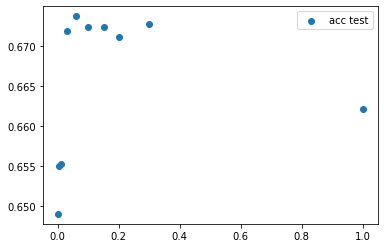

In [2989]:
acc_test = list()
acc_train = list()

reg_strengths = [0.001,0.005,0.01,0.03,0.06,0.1,0.15,0.2,0.3,1]
for c in reg_strengths:
    logreg = linear_model.LogisticRegression(solver="liblinear", penalty="l1", C=c)
    cv = cross_validate(logreg, x_train, y_train, cv=5)
    acc_test += [cv['test_score'].mean()]
  

plt.clf()
plt.scatter(reg_strengths,acc_test, label='acc test')
plt.legend()
plt.show()

In [2990]:
best_reg = reg_strengths[np.argmax(acc_test)]
print(best_reg)

0.06


In [2991]:
print(acc_test[np.argmax(acc_test)])

0.6737558904804496


In [2992]:
c = best_reg 
reg_logreg = linear_model.LogisticRegression(solver="liblinear", penalty="l1", C=c)
reg_logreg.fit(x_train, y_train)

LogisticRegression(C=0.06, penalty='l1', solver='liblinear')

In [2993]:
y_pred_reg = reg_logreg.predict(x_test)

In [2994]:
roc = roc_auc_score(y_test , y_pred_reg)
print(roc)

0.66802295207452


In [2995]:
rec = recall_score(y_test, y_pred_reg)
print(rec)

0.5427251732101617


In [2996]:
prec = precision_score(y_test, y_pred_reg)
print(prec)

0.6824782187802517


In [2997]:
used_descriptors = sum( reg_logreg.coef_[0] != 0)
print("We use ",used_descriptors,"features")

We use  11 features


In [2998]:
order = np.argsort(reg_logreg.coef_[0], axis=-1)[::-1]
order = order.tolist()
print(np.array(descriptor_names)[order[0:used_descriptors]])

['age_cat_Less than 25' 'sex_Male' 'juv_other_count' 'c_charge_degree_F'
 'priors_count' 'race_African-American' 'priors_count.1' 'juv_fel_count'
 'id' 'name_aajah herrington' 'name_telford wallace']


In [2999]:
fpr_log, tpr_log, thresholds =roc_curve(y_test, y_pred_reg)
roc_auc_log = auc(fpr_log, tpr_log)
print("True positive rate: ", tpr_log[1])
print("False positive rate: ", fpr_log[1])

True positive rate:  0.5427251732101617
False positive rate:  0.2066792690611216


In [3000]:
cm = confusion_matrix(y_test , y_pred_log)
positive_log = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_log = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_log)
print("Negative rate: ",negative_log)

Positive rate:  0.038115038115038115
Negative rate:  0.9618849618849619


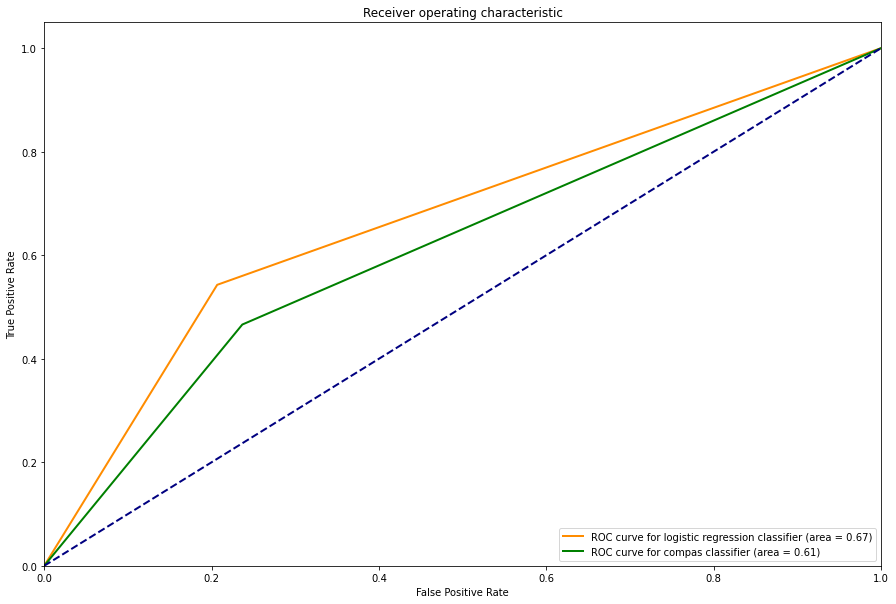

In [3001]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_log,
    tpr_log,
    color="darkorange",
    lw=lw,
    label="ROC curve for logistic regression classifier (area = %0.2f)" % roc_auc_log,
)
plt.plot(
    fpr_compas,
    tpr_compas,
    color="green",
    lw=lw,
    label="ROC curve for compas classifier (area = %0.2f)" % roc_auc_compas,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

We can see here that the area under the curve for this classifier is much bigger than the one of compas which makes it a better model

Check model fairness:

In [3002]:
blacks_pred_log = reg_logreg.predict(blacks_test_df)

In [3003]:
roc = roc_auc_score(target_blacks , blacks_pred_log)
print(roc)

0.6750718652208719


In [3004]:
fpr_blacks_log, tpr_blacks_log, thresholds =roc_curve(target_blacks, blacks_pred_log)
roc_auc_blacks_log = auc(fpr_blacks_log, tpr_blacks_log)
print("True positive rate: ", tpr_blacks_log[1])
print("False positive rate: ", fpr_blacks_log[1])

True positive rate:  0.6701986754966888
False positive rate:  0.32005494505494503


In [3005]:
cm = confusion_matrix(target_blacks , blacks_pred_log)
positive_blacks_log = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_blacks_log = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_blacks_log)
print("Negative rate: ",negative_blacks_log)

Positive rate:  0.4983142279163857
Negative rate:  0.5016857720836143


For whites:

In [3006]:
whites_pred_log = reg_logreg.predict(whites_test_df)

In [3007]:
roc = roc_auc_score(target_whites , whites_pred_log)
print(roc)

0.6347517891113326


In [3008]:
fpr_whites_log, tpr_whites_log, thresholds =roc_curve(target_whites, whites_pred_log)
roc_auc_whites_log = auc(fpr_whites_log, tpr_whites_log)
print("True positive rate: ", tpr_whites_log[1])
print("False positive rate: ", fpr_whites_log[1])

True positive rate:  0.37105263157894736
False positive rate:  0.10154905335628227


In [3009]:
cm = confusion_matrix(target_whites , whites_pred_log)
positive_whites_log = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_whites_log = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_whites_log)
print("Negative rate: ",negative_whites_log)

Positive rate:  0.2081165452653486
Negative rate:  0.7918834547346514


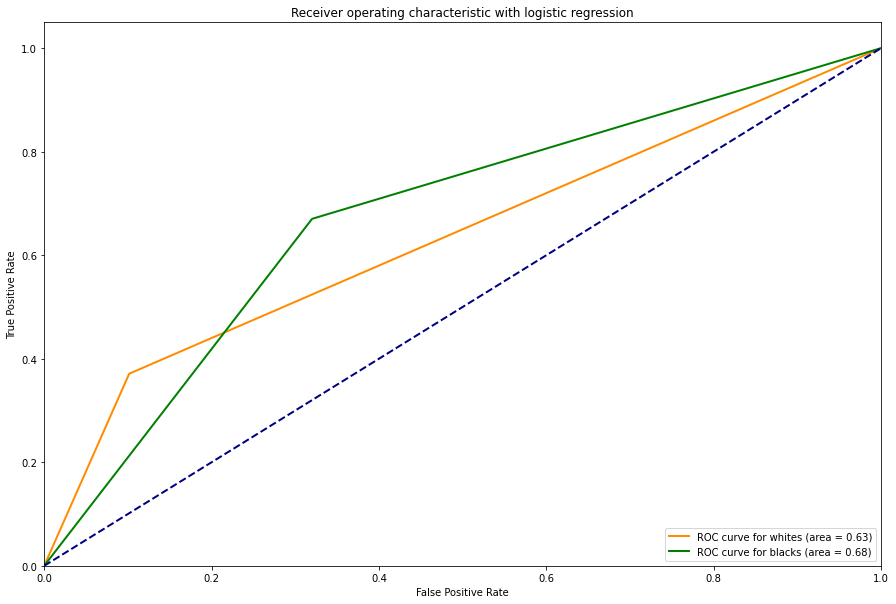

In [3010]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_whites_log,
    tpr_whites_log,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_whites_log,
)
plt.plot(
    fpr_blacks_log,
    tpr_blacks_log,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_blacks_log,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with logistic regression")
plt.legend(loc="lower right")
plt.show()

We can see from the roc curves that there's a bias against blacks they have a higher true posistive rate and a higher false positive rate compared to the whites

In [3011]:
positive_log_diff = positive_blacks_log - positive_whites_log
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_log_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.29019768265103707


In [3012]:
tpr_log_diff = tpr_blacks_log[1] - tpr_whites_log[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_log_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.2991460439177414


This makes this model unfair since the difference is higher than 20%

## Decision tree classifier

In [3013]:
clf_tree.fit(x_train, y_train);

In [3014]:
y_pred_tree = clf_tree.predict(x_test)

In [3015]:
used_descriptors = sum( clf_tree.feature_importances_!= 0)
print("We use ",used_descriptors,"features")

We use  643 features


In [3016]:
descriptor_names = x_train.columns
order = np.argsort(clf_tree.feature_importances_, axis=-1)[::-1]
order = order.tolist()
print("Features used ordered by descending importance:")
print(np.array(descriptor_names)[order[0:used_descriptors]])

Features used ordered by descending importance:
['id' 'age' 'priors_count.1' 'race_African-American' 'priors_count'
 'race_Caucasian' 'c_charge_degree_F' 'sex_Female' 'c_charge_degree_M'
 'juv_other_count' 'sex_Male' 'first_michael' 'last_smith' 'juv_fel_count'
 'race_Other' 'juv_misd_count' 'race_Hispanic' 'first_robert'
 'first_joshua' 'first_jeffrey' 'last_wright' 'last_williams'
 'last_johnson' 'first_justin' 'first_john' 'first_frederick' 'first_raul'
 'first_leroy' 'first_leon' 'first_daniel' 'first_natalie' 'first_victor'
 'first_roderick' 'last_patterson' 'first_patrick' 'age_cat_25 - 45'
 'first_luis' 'first_steve' 'first_adrian' 'first_matthew'
 'dob_1967-01-06' 'first_eduardo' 'first_nathaniel' 'dob_1963-07-31'
 'last_gray' 'first_christopher' 'age_cat_Greater than 45'
 'age_cat_Less than 25' 'first_lisa' 'last_ortiz' 'last_brown'
 'last_young' 'dob_1991-08-15' 'first_jason' 'first_clayton' 'last_payne'
 'first_jessica' 'last_martin' 'name_shelley bauman' 'last_ramkhelawan'


In [3017]:
roc = roc_auc_score(y_test , y_pred_tree)
print(roc)

0.62397860212378


In [3018]:
rec = recall_score(y_test, y_pred_tree)
print(rec)

0.5712086220169361


In [3019]:
prec = precision_score(y_test , y_pred_tree)
print(prec)

0.5912350597609561


In [3020]:
fpr_tree, tpr_tree, thresholds =roc_curve(y_test, y_pred_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)
print("True positive rate: ", tpr_tree[1])
print("False positive rate: ", fpr_tree[1])

True positive rate:  0.5712086220169361
False positive rate:  0.32325141776937616


In [3021]:
cm = confusion_matrix(y_test , y_pred_tree)
positive_tree = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_tree = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_tree)
print("Negative rate: ",negative_tree)

Positive rate:  0.43485793485793484
Negative rate:  0.5651420651420651


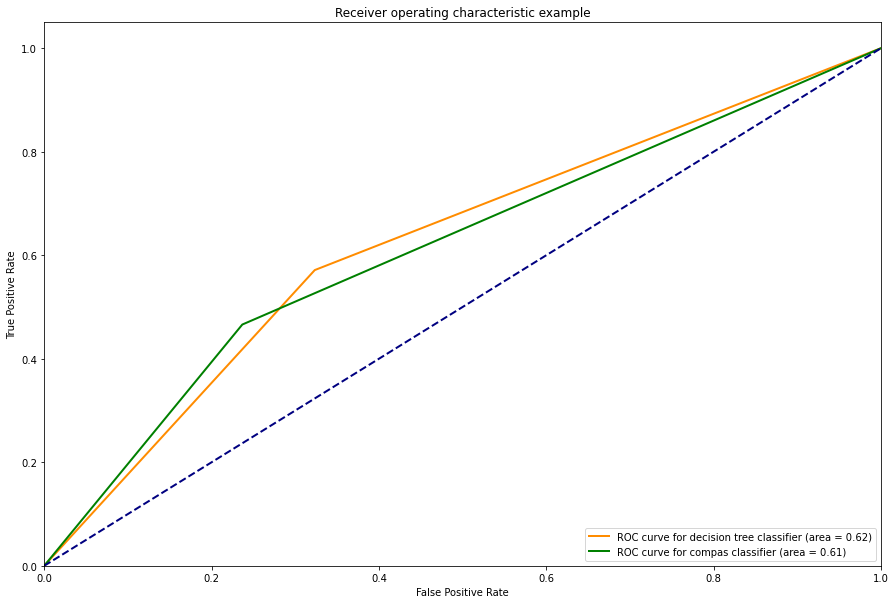

In [3022]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_tree,
    tpr_tree,
    color="darkorange",
    lw=lw,
    label="ROC curve for decision tree classifier (area = %0.2f)" % roc_auc_tree,
)
plt.plot(
    fpr_compas,
    tpr_compas,
    color="green",
    lw=lw,
    label="ROC curve for compas classifier (area = %0.2f)" % roc_auc_compas,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

We can see in the roc curve that this model has a higher true positive rate but also a higher false positive rate compared to compas which not ideal

Check model fairness

In [3023]:
blacks_pred_tree = clf_tree.predict(blacks_test_df)

In [3024]:
roc = roc_auc_score(target_blacks , blacks_pred_tree)
print(roc)

0.6257686849574267


In [3033]:
fpr_blacks_tree, tpr_blacks_tree, thresholds =roc_curve(target_blacks, blacks_pred_tree)
roc_auc_tree_blacks = auc(fpr_blacks_tree, tpr_blacks_tree)
print("True positive rate: ", tpr_blacks_tree[1])
print("False positive rate: ", fpr_blacks_tree[1])

True positive rate:  0.6622516556291391
False positive rate:  0.4107142857142857


In [3026]:
cm = confusion_matrix(target_blacks , blacks_pred_tree)
positive_blacks_tree = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_blacks_tree = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_blacks_tree)
print("Negative rate: ",negative_blacks_tree)

Positive rate:  0.5387727579231288
Negative rate:  0.4612272420768712


For whites:

In [3027]:
whites_pred_tree = clf_tree.predict(whites_test_df)

In [3028]:
roc = roc_auc_score(target_whites , whites_pred_tree)
print(roc)

0.5911540900443881


In [3032]:
fpr_whites_tree, tpr_whites_tree, thresholds =roc_curve(target_whites, whites_pred_tree)
roc_auc_tree_whites = auc(fpr_whites_tree, tpr_whites_tree)
print("True positive rate: ", tpr_whites_tree[1])
print("False positive rate: ", fpr_whites_tree[1])

True positive rate:  0.4473684210526316
False positive rate:  0.26506024096385544


In [3030]:
cm = confusion_matrix(target_whites , whites_pred_tree)
positive_whites_tree = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_whites_tree = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_whites_tree)
print("Negative rate: ",negative_whites_tree)

Positive rate:  0.33714880332986474
Negative rate:  0.6628511966701353


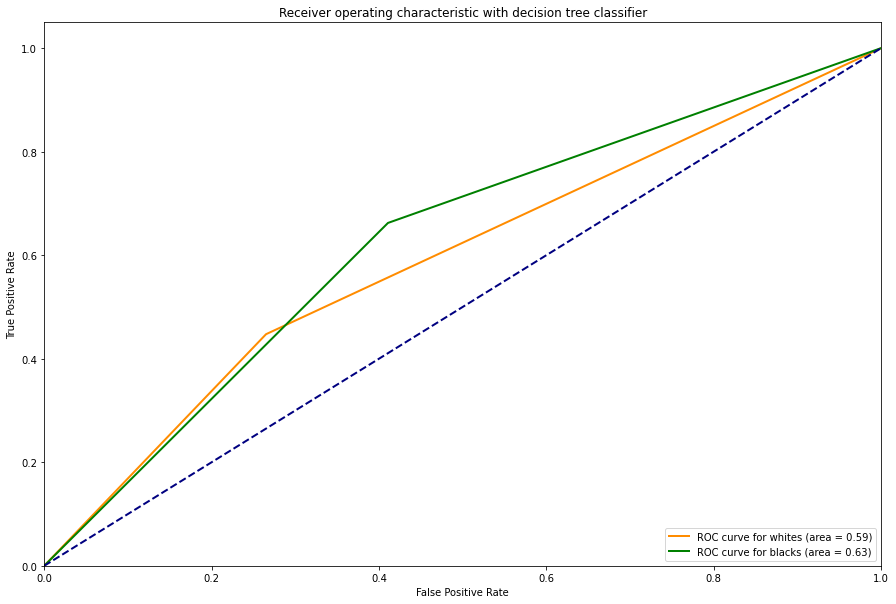

In [3034]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_whites_tree,
    tpr_whites_tree,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_tree_whites,
)
plt.plot(
    fpr_blacks_tree,
    tpr_blacks_tree,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_tree_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with decision tree classifier")
plt.legend(loc="lower right")
plt.show()

We can see from this graph that the model predicts better for blacks than for whites which indicates a bias

In [3035]:
positive_tree_diff = positive_blacks_tree - positive_whites_tree
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_tree_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.2016239545932641


In [3036]:
tpr_tree_diff = tpr_blacks_tree[1] - tpr_whites_tree[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_tree_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.21488323457650754


The decision tree classifier even though it has lower score it's slightly more fair than logistic regression classifier

## KNeighbors Classifier

In [3037]:
clf_nn.fit(x_train, y_train); 

In [3038]:
y_pred_nn = clf_nn.predict(x_test)

In [3039]:
roc = roc_auc_score(y_test , y_pred_nn)
print(roc)

0.5280978097154856


In [3040]:
rec = recall_score(y_test, y_pred_nn)
print(rec)

0.22632794457274827


In [3041]:
prec = precision_score(y_test , y_pred_nn)
print(prec)

0.5212765957446809


In [3042]:
fpr_nn, tpr_nn, thresholds =roc_curve(y_test, y_pred_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)
print("True positive rate: ", tpr_nn[1])
print("False positive rate: ", fpr_nn[1])

True positive rate:  0.22632794457274827
False positive rate:  0.17013232514177692


In [3043]:
cm = confusion_matrix(y_test , y_pred_nn)
positive_nn = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_nn = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_nn)
print("Negative rate: ",negative_nn)

Positive rate:  0.19542619542619544
Negative rate:  0.8045738045738046


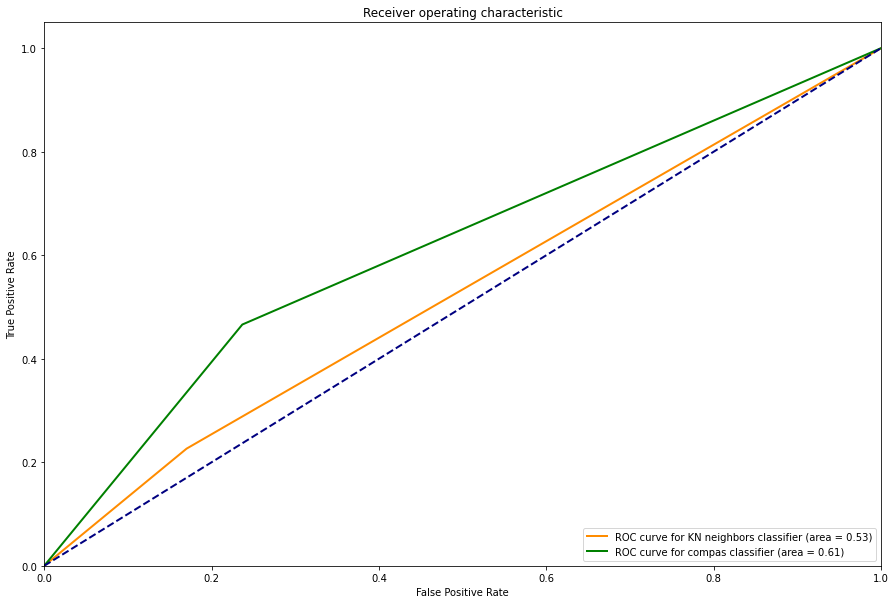

In [3044]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_nn,
    tpr_nn,
    color="darkorange",
    lw=lw,
    label="ROC curve for KN neighbors classifier (area = %0.2f)" % roc_auc_nn,
)
plt.plot(
    fpr_compas,
    tpr_compas,
    color="green",
    lw=lw,
    label="ROC curve for compas classifier (area = %0.2f)" % roc_auc_compas,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

We can see here that the area under the curve for this classifier is much smaller than the one of compas which makes it not a good model

We will now check the fairness

In [3045]:
blacks_pred_nn = clf_nn.predict(blacks_test_df)

In [3046]:
roc = roc_auc_score(target_blacks , blacks_pred_nn)
print(roc)

0.5343588530674623


In [3055]:
fpr_blacks_nn, tpr_blacks_nn, thresholds =roc_curve(target_blacks, blacks_pred_tree)
roc_auc_nn_blacks = auc(fpr_blacks_nn, tpr_blacks_nn)
print("True positive rate: ", tpr_blacks_nn[1])
print("False positive rate: ", fpr_blacks_nn[1])

True positive rate:  0.6622516556291391
False positive rate:  0.4107142857142857


In [3048]:
cm = confusion_matrix(target_blacks , blacks_pred_nn)
positive_blacks_nn = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_blacks_nn = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_blacks_nn)
print("Negative rate: ",negative_blacks_nn)

Positive rate:  0.22454484153742413
Negative rate:  0.7754551584625758


Do same thing for whites:

In [3049]:
whites_pred_nn = clf_nn.predict(whites_test_df)

In [3050]:
roc = roc_auc_score(target_whites , whites_pred_tree)
print(roc)

0.5911540900443881


In [3054]:
fpr_whites_nn, tpr_whites_nn, thresholds =roc_curve(target_whites, whites_pred_nn)
roc_auc_nn_whites = auc(fpr_whites_nn, tpr_whites_nn)
print("True positive rate: ", tpr_whites_nn[1])
print("False positive rate: ", fpr_whites_nn[1])

True positive rate:  0.18157894736842106
False positive rate:  0.153184165232358


In [3053]:
cm = confusion_matrix(target_whites , whites_pred_nn)
positive_whites_nn = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_whites_nn = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_whites_nn)
print("Negative rate: ",negative_whites_nn)

Positive rate:  0.16441207075962538
Negative rate:  0.8355879292403746


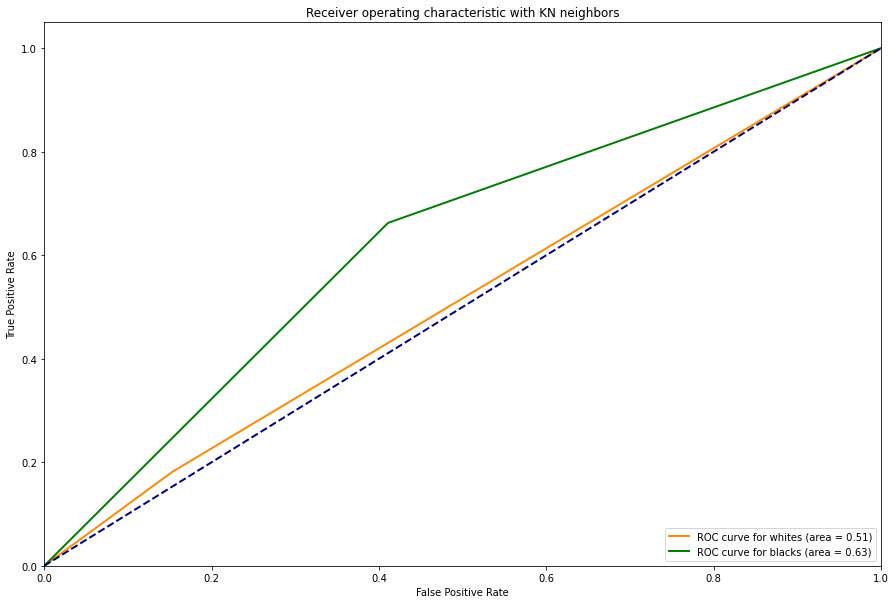

In [3056]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_whites_nn,
    tpr_whites_nn,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_nn_whites,
)
plt.plot(
    fpr_blacks_nn,
    tpr_blacks_nn,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_nn_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with KN neighbors")
plt.legend(loc="lower right")
plt.show()

We can from this curve that the model is very biased towards the blacks since for blacks the true positive rate is much higher than the one for whites.

In [3057]:
positive_nn_diff = positive_blacks_nn - positive_whites_nn
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_nn_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.060132770777798744


In [3058]:
tpr_nn_diff = tpr_blacks_nn[1] - tpr_whites_nn[1] 
print("The true positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_nn_diff)

The true positive rate for blacks is higher than the one for whites by a ratio of:  0.48067270826071806


KN neighbors bias againt blacks is just 6% which makes it the most fair classifier so far according to law 1 but it's highly unfair according to law 2, and it has the lowest roc score

# Fair classifier

Current features used:

In [3059]:
clean_df.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'c_charge_degree', 'priors_count.1', 'two_year_recid'],
      dtype='object')

We will start by removing sensitive information except the race from the data set

In [3060]:
fair_df = clean_df.copy()

In [3061]:
fair_df = clean_df.drop(columns=['first', 'last', 'name', 'id', 'sex', 'dob', 'age', 'age_cat']).copy()

In [3062]:
fair_dum_df = pd.get_dummies(fair_df)

In [3063]:
fair_dum_df.head()

juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0              0               0                0             0   
1              0               0                0             0   
2              0               0                1             4   
3              0               1                0             1   
4              0               0                0             2   

   priors_count.1  two_year_recid  race_African-American  race_Asian  \
0               0               0                      0           0   
1               0               1                      1           0   
2               4               1                      1           0   
3               1               0                      1           0   
4               2               0                      0           0   

   race_Caucasian  race_Hispanic  race_Native American  race_Other  \
0               0              0                     0           1   
1               0              0                     0           0   
2               0              0                     0           0   
3               0              0                     0           0   
4               0              0                     0           1   

   c_charge_degree_F  c_charge_degree_M  
0                  1                  0  
1                  1                  0  
2                  1                  0  
3                  1                  0  
4                  1                  0

In [3064]:
# Split data into 60% train and 40% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    fair_dum_df, fair_dum_df['two_year_recid'], test_size=0.4, shuffle=True
)

In [3065]:
nb_samples_train = len(y_train)
nb_samples_test = len(y_test)

nb_train_positives = sum(y_train) 
nb_test_positives = sum(y_test) 
train_positive_ratio = nb_train_positives/nb_samples_train 
test_positive_ratio = nb_test_positives/nb_samples_test 
train_blacks_ratio = len(x_train[(x_train['race_African-American']==1) & (x_train['two_year_recid']==1)])/len(x_train[x_train['two_year_recid']==1])
train_whites_ratio = len(x_train[(x_train['race_Caucasian']==1) & (x_train['two_year_recid']==1)])/len(x_train[x_train['two_year_recid']==1])
test_blacks_ratio = len(x_test[(x_test['race_African-American']==1) & (x_test['two_year_recid']==1)])/len(x_test[x_test['two_year_recid']==1])
test_whites_ratio = len(x_test[(x_test['race_Caucasian']==1) & (x_test['two_year_recid']==1)])/len(x_test[x_test['two_year_recid']==1])

print("Nb samples train", nb_samples_train)
print("Nb samples test", nb_samples_test)
print("Nb of positive train samples", nb_train_positives)
print("Nb of positive test samples", nb_test_positives)
print("Train Positive Ratio:", train_positive_ratio)
print("Test Positive Ratio:", test_positive_ratio)
print("Train recid blacks Ratio:", train_blacks_ratio)
print("Train recid whites Ratio:", train_whites_ratio)
print("Test recid blacks Ratio:", test_blacks_ratio)
print("Test recid whites Ratio:", test_whites_ratio)

Nb samples train 4328
Nb samples test 2886
Nb of positive train samples 1936
Nb of positive test samples 1315
Train Positive Ratio: 0.44731977818853974
Test Positive Ratio: 0.4556479556479556
Train recid blacks Ratio: 0.5681818181818182
Train recid whites Ratio: 0.31043388429752067
Test recid blacks Ratio: 0.6091254752851711
Test recid whites Ratio: 0.27756653992395436


Copy data in a separate data frame for blacks and whites

In [3066]:
blacks_test_df = x_test[x_test['race_African-American']==1].copy()

In [3067]:
target_blacks = blacks_test_df['two_year_recid']

In [3068]:
whites_test_df = x_test[x_test['race_Caucasian']==1].copy()

In [3069]:
target_whites = whites_test_df['two_year_recid']

Drop race colmun for training and test sets

In [3070]:
x_train.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

/home/im2ag/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3071]:
x_test.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

In [3072]:
blacks_test_df.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

In [3073]:
whites_test_df.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

## Decision tree

Fit data using decision tree

In [3074]:
clf_tree.fit(x_train, y_train);

In [3075]:
y_pred_fair_tree = clf_tree.predict(x_test)

In [3076]:
roc = roc_auc_score(y_test , y_pred_fair_tree)
print(roc)

0.6153347387171959


In [3077]:
used_descriptors = sum( clf_tree.feature_importances_!= 0)
print("We use ",used_descriptors,"features")

We use  7 features


In [3078]:
descriptor_names = x_train.columns
order = np.argsort(clf_tree.feature_importances_, axis=-1)[::-1]
order = order.tolist()
print(np.array(descriptor_names)[order[0:used_descriptors]])

['priors_count' 'juv_other_count' 'priors_count.1' 'juv_misd_count'
 'juv_fel_count' 'c_charge_degree_F' 'c_charge_degree_M']


In [3080]:
fpr_fair_tree, tpr_fair_tree, thresholds =roc_curve(y_test, y_pred_fair_tree)
roc_auc_fair_tree = auc(fpr_fair_tree, tpr_fair_tree)
print("True positive rate: ", tpr_fair_tree[1])
print("False positive rate: ", fpr_fair_tree[1])

True positive rate:  0.4311787072243346
False positive rate:  0.2005092297899427


In [3081]:
cm = confusion_matrix(y_test , y_pred_fair_tree)
#(tn, fp, fn, tp)

In [3082]:
print("Positive rate: ",(cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))

Positive rate:  0.30561330561330563


In [3083]:
print("Negative rate: ",(cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))

Negative rate:  0.6943866943866944


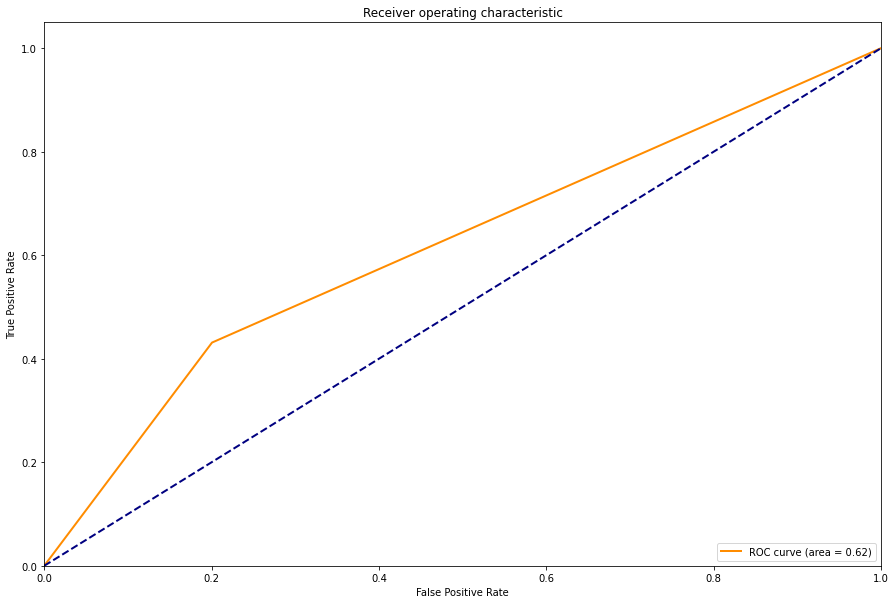

In [3084]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_fair_tree,
    tpr_fair_tree,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_fair_tree,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

From the curve we can see that the model is not bad when it comes to predictions

Now we will check model fairness with respect to race

First compute different metrics for blacks

In [3085]:
blacks_pred_tree = clf_tree.predict(blacks_test_df)

In [3086]:
roc = roc_auc_score(target_blacks , blacks_pred_tree)
print(roc)

0.5996956238330405


In [3087]:
prec = precision_score(target_blacks , blacks_pred_tree)
print(prec)

0.6695804195804196


In [3088]:
fpr_blacks, tpr_blacks, thresholds =roc_curve(target_blacks, blacks_pred_tree)
roc_auc_blacks = auc(fpr_blacks, tpr_blacks)
print("True positive rate: ", tpr_blacks[1])
print("False positive rate: ", fpr_blacks[1])

True positive rate:  0.4781523096129838
False positive rate:  0.27876106194690264


In [3089]:
cm = confusion_matrix(target_blacks , blacks_pred_tree)
positive_blacks = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_blacks = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_blacks)
print("Negative rate: ",negative_blacks)

Positive rate:  0.3867478025693036
Negative rate:  0.6132521974306964


Compute metrics for whites

In [3090]:
whites_pred_tree = clf_tree.predict(whites_test_df)

In [3091]:
roc = roc_auc_score(target_whites , whites_pred_tree)
print(roc)

0.6068493150684932


In [3092]:
prec = precision_score(target_whites , whites_pred_tree)
print(prec)

0.6018099547511312


In [3093]:
fpr_whites, tpr_whites, thresholds =roc_curve(target_whites, whites_pred_tree)
roc_auc_whites = auc(fpr_whites, tpr_whites)
print("True positive rate: ", tpr_whites[1])
print("False positive rate: ", fpr_whites[1])

True positive rate:  0.3643835616438356
False positive rate:  0.1506849315068493


In [3094]:
cm = confusion_matrix(target_whites , whites_pred_tree)
positive_whites = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_whites = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_whites)
print("Negative rate: ",negative_whites)

Positive rate:  0.2328767123287671
Negative rate:  0.7671232876712328


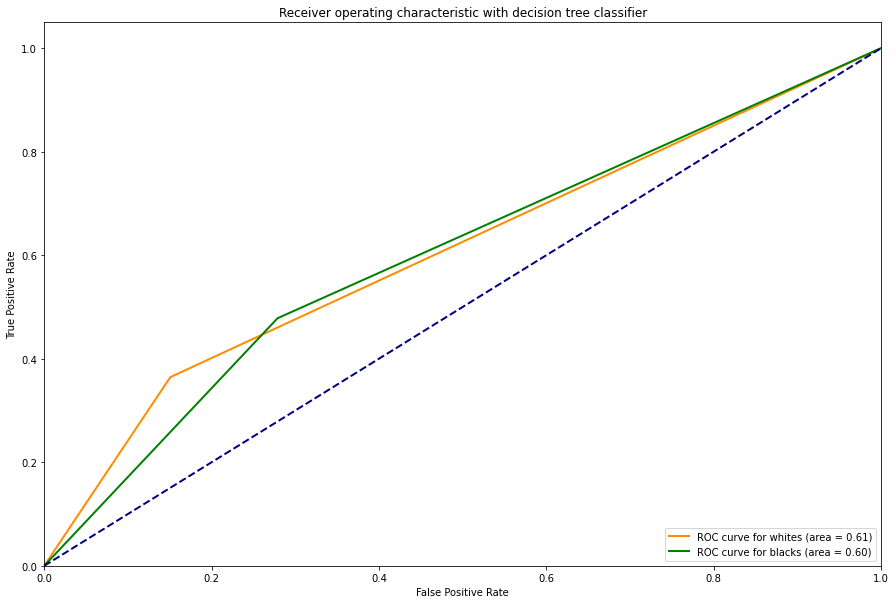

In [3095]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_whites,
    tpr_whites,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_whites,
)
plt.plot(
    fpr_blacks,
    tpr_blacks,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with decision tree classifier")
plt.legend(loc="lower right")
plt.show()

From the roc curves we can see that the model is biased twowards blacks, blacks have a higher true positive rate than the whites, and the whites have lower false positive rate compared to blacks

In [3096]:
positive_diff = positive_blacks - positive_whites 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.15387109024053647


In [3097]:
negative_diff = negative_whites - negative_blacks 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",negative_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.15387109024053647


In [3098]:
tpr_diff = tpr_blacks[1] - tpr_whites[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.11376874796914815


This model is more fair than Compas, but it still has 15% bias towards blacks, and it 13% bias according to law 2

## Logistic regression

We fit the data using logistic regression:

In [3099]:
clf_log_b.fit(x_train, y_train);

In [3100]:
pred_log_b = clf_log_b.predict(x_test)

In [3101]:
roc = roc_auc_score(y_test , pred_log_b)
print(roc)

0.6300089792895469


In [3102]:
descriptor_names = x_train.columns
used_descriptors = sum( clf_log_b.coef_[0] != 0)
order = np.argsort(clf_log_b.coef_[0], axis=-1)[::-1]
order = order.tolist()
print("uses ", used_descriptors, "features")
print(np.array(descriptor_names)[order[0:used_descriptors]])

uses  7 features
['juv_other_count' 'juv_fel_count' 'juv_misd_count' 'priors_count.1'
 'priors_count' 'c_charge_degree_F' 'c_charge_degree_M']


We use regularization using the l1 penalty to reduce number of features used

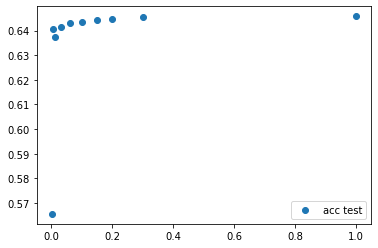

In [3103]:
acc_test = list()
acc_train = list()

reg_strengths = [0.001,0.005,0.01,0.03,0.06,0.1,0.15,0.2,0.3,1]
for c in reg_strengths:
    logreg = linear_model.LogisticRegression(solver="liblinear", penalty="l1", C=c)
    cv = cross_validate(logreg, x_train, y_train, cv=5)
    acc_test += [cv['test_score'].mean()]
  

plt.clf()
plt.scatter(reg_strengths,acc_test, label='acc test')
plt.legend()
plt.show()

In [3104]:
best_reg = reg_strengths[np.argmax(acc_test)]
print(best_reg)

1


In [3105]:
print(acc_test[np.argmax(acc_test)])

0.6457944973234191


In [3106]:
c =  best_reg 
reg_logreg = linear_model.LogisticRegression(solver="liblinear", penalty="l1", C=c)
reg_logreg.fit(x_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [3107]:
descriptor_names = x_train.columns
used_descriptors = sum( reg_logreg.coef_[0] != 0)
order = np.argsort(reg_logreg.coef_[0], axis=-1)[::-1]
order = order.tolist()
print("uses ", used_descriptors, "features")
print(np.array(descriptor_names)[order[0:used_descriptors]])

uses  6 features
['juv_other_count' 'juv_fel_count' 'juv_misd_count' 'priors_count'
 'priors_count.1' 'c_charge_degree_F']


Fit the data using the regularized model

In [3108]:
pred_log_b = reg_logreg.predict(x_test)

In [3109]:
roc = roc_auc_score(y_test , pred_log_b)
print(roc)

0.6303272479082611


In [3110]:
rec = recall_score(y_test , pred_log_b)
print(rec)

0.4159695817490494


Predict on blacks data set:

In [3111]:
blacks_pred_log = reg_logreg.predict(blacks_test_df)

In [3112]:
roc = roc_auc_score(target_blacks , blacks_pred_log)
print(roc)

0.6211372951951654


In [3113]:
rec = recall_score(target_blacks , blacks_pred_log)
print(rec)

0.46941323345817726


In [3114]:
prec = precision_score(target_blacks , blacks_pred_log)
print(prec)

0.7094339622641509


In [3115]:
fpr_fair_log_blacks, tpr_fair_log_blacks, thresholds =roc_curve(target_blacks, blacks_pred_log)
roc_auc_fair_log_blacks = auc(fpr_fair_log_blacks, tpr_fair_log_blacks)
print("True positive rate for blacks: ", tpr_fair_log_blacks[1])
print("False positive rate for blacks: ", fpr_fair_log_blacks[1])

True positive rate for blacks:  0.46941323345817726
False positive rate for blacks:  0.22713864306784662


In [3116]:
cm = confusion_matrix(target_blacks , blacks_pred_log)
positive_fair_log_blacks = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_fair_log_blacks = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate for blacks: ",positive_blacks)
print("Negative rate for blacks: ",negative_blacks)

Positive rate for blacks:  0.3867478025693036
Negative rate for blacks:  0.6132521974306964


Now for whites dataset:

In [3117]:
whites_pred_log = reg_logreg.predict(whites_test_df)

In [3118]:
roc = roc_auc_score(target_whites , whites_pred_log)
print("ROC score for whites: ", roc)

ROC score for whites:  0.6167808219178083


In [3119]:
rec = recall_score(target_whites , whites_pred_log)
print("Recall score for whites:", rec)

Recall score for whites: 0.35342465753424657


In [3120]:
prec = precision_score(target_whites , whites_pred_log)
print("Precision score for whites: ", prec)

Precision score for whites:  0.6482412060301508


In [3121]:
fpr_fair_log_whites, tpr_fair_log_whites, thresholds =roc_curve(target_whites, whites_pred_log)
roc_auc_fair_log_whites = auc(fpr_fair_log_whites, tpr_fair_log_whites)
print("True positive rate for whites: ", tpr_fair_log_whites[1])
print("False positive rate for whites: ", fpr_fair_log_whites[1])

True positive rate for whites:  0.35342465753424657
False positive rate for whites:  0.11986301369863013


In [3122]:
cm = confusion_matrix(target_whites , whites_pred_log)
positive_fair_log_whites = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_fair_log_whites = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate for whites: ",positive_fair_log_whites)
print("Negative rate whites: ",negative_fair_log_whites)

Positive rate for whites:  0.20969441517386722
Negative rate whites:  0.7903055848261328


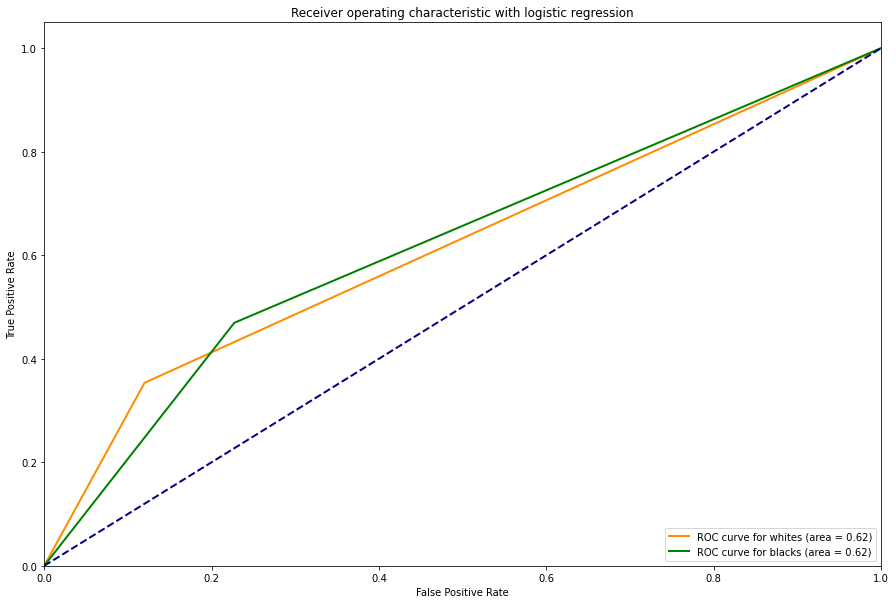

In [3123]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_fair_log_whites,
    tpr_fair_log_whites,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_fair_log_whites,
)
plt.plot(
    fpr_fair_log_blacks,
    tpr_fair_log_blacks,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_fair_log_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with logistic regression")
plt.legend(loc="lower right")
plt.show()

From the roc curves we can see that the model is biased twowards blacks, blacks have a higher true positive rate than the whites, and the whites have lower false positive rate compared to blacks

In [3124]:
positive_diff = positive_fair_log_blacks - positive_fair_log_whites 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.1486558214725155


In [3125]:
tpr_diff = tpr_fair_log_blacks[1] - tpr_fair_log_whites[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.11598857592393069


We can see that the model using logistic regression has 14% bias againt blacks according to law 1 and also 11% bias according to law 2

## KN neighbors

In [3126]:
clf_nn.fit(x_train, y_train); 

In [3127]:
y_pred_fair_nn = clf_nn.predict(x_test)

In [3128]:
roc = roc_auc_score(y_test , y_pred_fair_nn)
print(roc)

0.5769941404690045


In [3129]:
blacks_pred_fair_nn = clf_nn.predict(blacks_test_df)

In [3130]:
roc = roc_auc_score(target_blacks , blacks_pred_fair_nn)
print(roc)

0.569144763735596


In [3131]:
fpr_fair_nn_blacks, tpr_fair_nn_blacks, thresholds =roc_curve(target_blacks, blacks_pred_fair_nn)
roc_auc_fair_nn_blacks = auc(fpr_fair_nn_blacks, tpr_fair_nn_blacks)
print("True positive rate for blacks: ", tpr_fair_nn_blacks[1])
print("False positive rate for blacks: ", fpr_fair_nn_blacks[1])

True positive rate for blacks:  0.29463171036204744
False positive rate for blacks:  0.15634218289085547


In [3132]:
cm = confusion_matrix(target_blacks , blacks_pred_fair_nn)
positive_fair_nn_blacks = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_fair_nn_blacks = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate for blacks: ", positive_fair_nn_blacks)
print("Negative rate for blacks: ", negative_fair_nn_blacks)

Positive rate for blacks:  0.23123732251521298
Negative rate for blacks:  0.768762677484787


For whites:

In [3133]:
whites_pred_fair_nn = clf_nn.predict(whites_test_df)

In [3134]:
roc = roc_auc_score(target_whites , whites_pred_fair_nn)
print(roc)

0.5707191780821917


In [3135]:
fpr_fair_nn_whites, tpr_fair_nn_whites, thresholds =roc_curve(target_whites, whites_pred_fair_nn)
roc_auc_fair_nn_whites = auc(fpr_fair_nn_whites, tpr_fair_nn_whites)
print("True positive rate for whites: ", tpr_fair_nn_whites[1])
print("False positive rate for whites: ", fpr_fair_nn_whites[1])

True positive rate for whites:  0.2356164383561644
False positive rate for whites:  0.09417808219178082


In [3136]:
cm = confusion_matrix(target_whites , whites_pred_fair_nn)
positive_fair_nn_whites = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_fair_nn_whites = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate for whites: ", positive_fair_nn_whites)
print("Negative rate for whites: ", negative_fair_nn_whites)

Positive rate for whites:  0.14857744994731295
Negative rate for whites:  0.8514225500526871


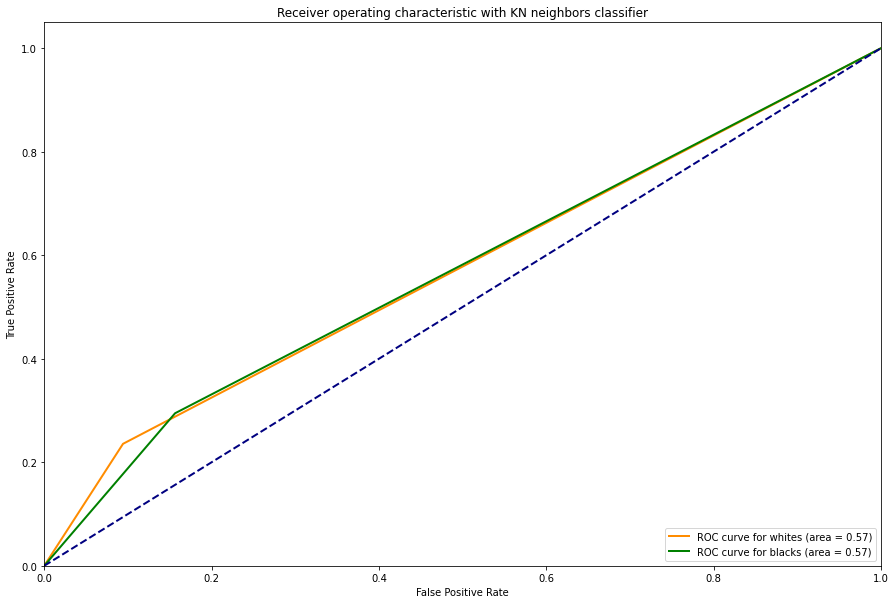

In [3137]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_fair_nn_whites,
    tpr_fair_nn_whites,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_fair_nn_whites,
)
plt.plot(
    fpr_fair_nn_blacks,
    tpr_fair_nn_blacks,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_fair_nn_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with KN neighbors classifier")
plt.legend(loc="lower right")
plt.show()

From the roc curves we can see that this gives a lower positive rate compared to previous classifiers and the distance between the true positive rate of the blacks and whites is smaller but it still has a higher false positive rate for blacks compared to whites.

In [3138]:
positive_diff = positive_fair_nn_blacks - positive_fair_nn_whites 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.08265987256790003


In [3139]:
tpr_diff = tpr_fair_nn_blacks[1] - tpr_fair_nn_whites[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.05901527200588305


This model is only 8% biased according to law 1 and only 5% biased according to law 2

# Fair classifier using law 1

## Data preparation

We start some analysis to better understand why we still have bias againt blacks even thought we removed race feature from the data set

In [2830]:
fair_l1_df = pd.get_dummies(fair_df)

In [2831]:
blacks_ratio = len(fair_l1_df[(fair_l1_df['race_African-American']==1) & (fair_l1_df['two_year_recid']==1)])/len(fair_l1_df[fair_l1_df['two_year_recid']==1])
print("Ratio of blacks having recidivated in two years: ", blacks_ratio)

Ratio of blacks having recidivated in two years:  0.5847431559520148


In [2832]:
whites_ratio = len(fair_l1_df[(fair_l1_df['race_Caucasian']==1) & (fair_l1_df['two_year_recid']==1)])/len(fair_l1_df[fair_l1_df['two_year_recid']==1])
print("Ratio of whites having recidivated in two years: ", whites_ratio)

Ratio of whites having recidivated in two years:  0.29713934174100276


In [2833]:
print("Features used in previous model: ", np.array(descriptor_names)[order[0:used_descriptors]])

Features used in previous model:  ['juv_other_count' 'juv_fel_count' 'juv_misd_count' 'priors_count'
 'priors_count.1' 'c_charge_degree_F']


Since we have a higher number of blacks who recidivated in our data set compared to whites we can deduce that the features used by the model to predict recidivism will be highly correlated with race so that's why we still get biased results, and due to the fact that there are more blacks who recidivated than there are whites

In [2834]:
nb_recid_blacks = len(fair_l1_df[(fair_l1_df['race_African-American']==1) & (fair_l1_df['two_year_recid']==1)])
print("Number of blacks who recidivated in two years: ", nb_recid_blacks)

Number of blacks who recidivated in two years:  1901


Choose the number of entries to drop for blacks

In [2835]:
nb_idx = round(nb_recid_blacks/2) + 400
print("Number of black recid to drop", nb_idx)

Number of black recid to drop 1350


In [2836]:
print("Black recid left: ", nb_recid_blacks-nb_idx)

Black recid left:  551


In [2828]:
print("White recid: ",len(fair_l1_df[(fair_l1_df['race_Caucasian']==1)  & (fair_l1_df['two_year_recid']==1)]))

White recid:  966


In [2837]:
indexes = fair_l1_df[(fair_l1_df['race_African-American']==1) & (fair_l1_df['two_year_recid']==1)].index
print("Indexes to drop: ", indexes)

Indexes to drop:  Int64Index([   1,    2,   11,   15,   20,   21,   27,   29,   30,   32,
            ...
            7172, 7174, 7181, 7183, 7189, 7190, 7195, 7200, 7201, 7207],
           dtype='int64', length=1901)


We can use two methods we though if keeping the data and doing `fair_dum_df.loc[indexes[:nb_idx], 'two_year_recid'] = 0` to set some predictions to 0 for blacks but this method decreases model accuracy since a lot of feature values corresponding to positive predictions will be wrong, so we will use the second method which is eliminate some entries in blacks recidivied.

In [2838]:
fair_l1_df.drop(indexes[:nb_idx], inplace=True)

In [2839]:
blacks_ratio = len(fair_l1_df[(fair_l1_df['race_African-American']==1) & (fair_l1_df['two_year_recid']==1)])/len(fair_l1_df[fair_l1_df['two_year_recid']==1])
print("Ratio of blacks having recidivated in two years: ", blacks_ratio)

Ratio of blacks having recidivated in two years:  0.2898474487112046


In [2840]:
whites_ratio = len(fair_l1_df[(fair_l1_df['race_Caucasian']==1) & (fair_l1_df['two_year_recid']==1)])/len(fair_l1_df[fair_l1_df['two_year_recid']==1])
print("Ratio of whites having recidivated in two years: ", whites_ratio)

Ratio of whites having recidivated in two years:  0.5081536033666492


We have now reduced the number of blacks having recidivated

In [2841]:
# Split data into 60% train and 40% test subsets
x_train, x_test, y_train, y_test = train_test_split(
        fair_l1_df, fair_l1_df['two_year_recid'], test_size=0.4, shuffle=True
)

In [2842]:
nb_samples_train = len(y_train) # TODO
nb_samples_test = len(y_test) # TODO

nb_train_positives = sum(y_train) # TODO
nb_test_positives = sum(y_test) # TODO

train_positive_ratio = nb_train_positives/nb_samples_train # TODO
test_positive_ratio = nb_test_positives/nb_samples_test # TODO
train_blacks_ratio = len(x_train[(x_train['race_African-American']==1) & (x_train['two_year_recid']==1)])/len(x_train[x_train['two_year_recid']==1])
train_whites_ratio = len(x_train[(x_train['race_Caucasian']==1) & (x_train['two_year_recid']==1)])/len(x_train[x_train['two_year_recid']==1])
test_blacks_ratio = len(x_test[(x_test['race_African-American']==1) & (x_test['two_year_recid']==1)])/len(x_test[x_test['two_year_recid']==1])
test_whites_ratio = len(x_test[(x_test['race_Caucasian']==1) & (x_test['two_year_recid']==1)])/len(x_test[x_test['two_year_recid']==1])

print("Nb samples train", nb_samples_train)
print("Nb samples test", nb_samples_test)
print("Nb of positive train samples", nb_train_positives)
print("Nb of positive test samples", nb_test_positives)
print("Train Positive Ratio:", train_positive_ratio)
print("Test Positive Ratio:", test_positive_ratio)
print("Train recid blacks Ratio:", train_blacks_ratio)
print("Train recid whites Ratio:", train_whites_ratio)
print("Test recid blacks Ratio:", test_blacks_ratio)
print("Test recid whites Ratio:", test_whites_ratio)

Nb samples train 3518
Nb samples test 2346
Nb of positive train samples 1143
Nb of positive test samples 758
Train Positive Ratio: 0.3249005116543491
Test Positive Ratio: 0.32310315430520037
Train recid blacks Ratio: 0.29133858267716534
Train recid whites Ratio: 0.5013123359580053
Test recid blacks Ratio: 0.287598944591029
Test recid whites Ratio: 0.5184696569920845


In [2843]:
blacks_test_df = x_test[x_test['race_African-American']==1].copy()

In [2844]:
target_blacks = blacks_test_df['two_year_recid'].copy()

In [2845]:
whites_test_df = x_test[x_test['race_Caucasian']==1].copy()

In [2846]:
target_whites = whites_test_df['two_year_recid'].copy()

In [2847]:
x_train.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

/home/im2ag/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2848]:
x_test.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

In [2849]:
blacks_test_df.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

In [2850]:
whites_test_df.drop(columns=['two_year_recid', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other'], inplace=True)

## Decision tree

In [2851]:
clf_tree.fit(x_train, y_train);

In [2852]:
y_pred_tree = clf_tree.predict(x_test)

In [2853]:
roc = roc_auc_score(y_test , y_pred_tree)
print(roc)

0.5528094946930474


In [2858]:
blacks_pred_l1_tree = clf_tree.predict(blacks_test_df)

In [2859]:
roc = roc_auc_score(target_blacks , blacks_pred_l1_tree)
print(roc)

0.5760676329756174


In [2862]:
fpr_l1_tree_blacks, tpr_l1_tree_blacks, thresholds =roc_curve(target_blacks, blacks_pred_l1_tree)
roc_auc_l1_tree_blacks = auc(fpr_l1_tree_blacks, tpr_l1_tree_blacks)
print("True positive rate for blacks: ", tpr_l1_tree_blacks[1])
print("False positive rate for blacks: ", fpr_l1_tree_blacks[1])

True positive rate for blacks:  0.29357798165137616
False positive rate for blacks:  0.14144271570014144


In [2863]:
cm = confusion_matrix(target_blacks , blacks_pred_l1_tree)
positive_l1_tree_blacks = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_l1_tree_blacks = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate for blacks: ", positive_l1_tree_blacks)
print("Negative rate for blacks: ", negative_l1_tree_blacks)
#(tn, fp, fn, tp)

Positive rate for blacks:  0.1772972972972973
Negative rate for blacks:  0.8227027027027027


For whites:

In [2865]:
whites_pred_l1_tree = clf_tree.predict(whites_test_df)

In [2866]:
roc = roc_auc_score(target_whites , whites_pred_l1_tree)
print(roc)

0.561040621746437


In [2872]:
fpr_l1_tree_whites, tpr_l1_tree_whites, thresholds =roc_curve(target_whites, whites_pred_l1_tree)
roc_auc_l1_tree_whites = auc(fpr_l1_tree_whites, tpr_l1_tree_whites)
print("True positive rate for whites: ", tpr_l1_tree_whites[1])
print("False positive rate for whites: ", fpr_l1_tree_whites[1])

True positive rate for whites:  0.18829516539440203
False positive rate for whites:  0.06621392190152801


In [2870]:
cm = confusion_matrix(target_whites , whites_pred_l1_tree)
positive_l1_tree_whites = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_l1_tree_whites = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate for whites: ", positive_l1_tree_whites)
print("Negative rate for whites: ", negative_l1_tree_whites)

Positive rate for whites:  0.11507128309572301
Negative rate for whites:  0.884928716904277


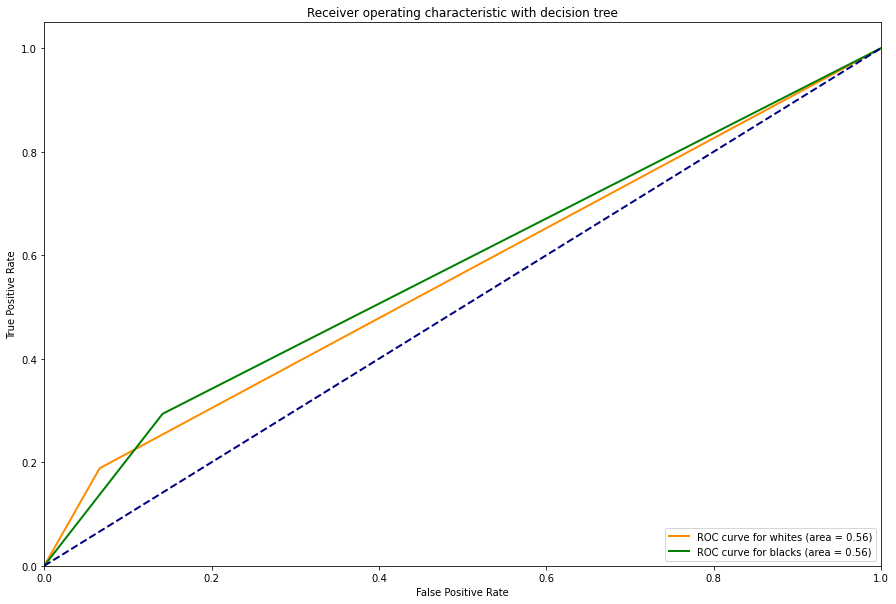

In [2873]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_l1_tree_whites,
    tpr_l1_tree_whites,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_l1_tree_whites,
)
plt.plot(
    fpr_l1_tree_blacks,
    tpr_l1_tree_blacks,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_l1_tree_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with decision tree")
plt.legend(loc="lower right")
plt.show()

We can see from the roc curves that the distances between the true positive and false positive rates for blacks and whites got much smaller compared to previous decision tree model, but at the same time it still has some bias

In [2876]:
positive_diff = positive_l1_tree_blacks - positive_l1_tree_whites 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.06222601420157428


In [2877]:
tpr_diff = tpr_l1_tree_blacks[1] - tpr_l1_tree_whites[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.10528281625697414


We now have 6% bias with respect to law 1, and 10% bias with respect to law 2

## KN neighors

In [2878]:
clf_nn.fit(x_train, y_train); 

In [2879]:
y_pred_l1_nn = clf_nn.predict(x_test)

In [2880]:
roc = roc_auc_score(y_test , y_pred_l1_nn)
print(roc)

0.5267250088061516


In [2881]:
fpr_l1_nn, tpr_l1_nn, thresholds =roc_curve(y_test, y_pred_l1_nn)
roc_auc_nn = auc(fpr_l1_nn, tpr_l1_nn)
print("True positive rate: ", tpr_l1_nn[1])
print("False positive rate: ", fpr_l1_nn[1])

True positive rate:  0.13720316622691292
False positive rate:  0.08375314861460957


In [2882]:
cm = confusion_matrix(y_test , y_pred_l1_nn)
positive_l1_nn = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_l1_nn = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ",positive_l1_nn)
print("Negative rate: ",negative_l1_nn)

Positive rate:  0.1010230179028133
Negative rate:  0.8989769820971867


In [2883]:
blacks_pred_l1_nn = clf_nn.predict(blacks_test_df)

In [2884]:
roc = roc_auc_score(target_blacks , blacks_pred_l1_nn)
print(roc)

0.528992512619545


In [2892]:
fpr_l1_nn_blacks, tpr_l1_nn_blacks, thresholds =roc_curve(target_blacks, blacks_pred_l1_nn)
roc_auc_l1_nn_blacks = auc(fpr_l1_nn_blacks, tpr_l1_nn_blacks)
print("True positive rate: ", tpr_l1_nn_blacks[1])
print("False positive rate: ", fpr_l1_nn_blacks[1])

True positive rate:  0.16972477064220184
False positive rate:  0.11173974540311174


In [2901]:
cm = confusion_matrix(target_blacks , blacks_pred_l1_nn)
positive_l1_nn_blacks = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_l1_nn_blacks = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ", positive_l1_blacks)
print("Negative rate: ", negative_l1_blacks)

Positive rate:  0.1254054054054054
Negative rate:  0.8745945945945945


For whites:

In [2894]:
whites_pred_l1_nn = clf_nn.predict(whites_test_df)

In [2895]:
roc = roc_auc_score(target_whites , whites_pred_l1_nn)
print(roc)

0.5288084777321288


In [2896]:
fpr_l1_nn_whites, tpr_l1_nn_whites, thresholds =roc_curve(target_whites, whites_pred_l1_nn)
roc_auc_l1_nn_whites = auc(fpr_l1_nn_whites, tpr_l1_nn_whites)
print("True positive rate: ", tpr_l1_nn_whites[1])
print("False positive rate: ", fpr_l1_nn_whites[1])

True positive rate:  0.1272264631043257
False positive rate:  0.06960950764006792


In [2897]:
cm = confusion_matrix(target_whites , whites_pred_l1_nn)
positive_l1_nn_whites = (cm[0][1]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
negative_l1_nn_whites = (cm[0][0]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Positive rate: ", positive_l1_nn_whites)
print("Negative rate: ", negative_l1_nn_whites)

Positive rate:  0.09266802443991853
Negative rate:  0.9073319755600815


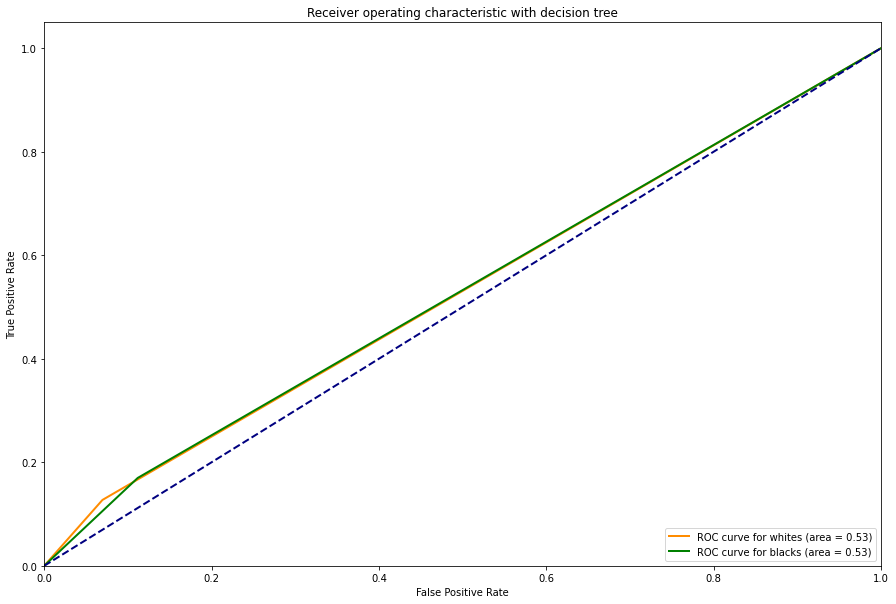

In [2899]:
plt.figure(figsize=(15,10))
lw = 2
plt.plot(
    fpr_l1_nn_whites,
    tpr_l1_nn_whites,
    color="darkorange",
    lw=lw,
    label="ROC curve for whites (area = %0.2f)" % roc_auc_l1_nn_whites,
)
plt.plot(
    fpr_l1_nn_blacks,
    tpr_l1_nn_blacks,
    color="green",
    lw=lw,
    label="ROC curve for blacks (area = %0.2f)" % roc_auc_l1_nn_blacks,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with decision tree")
plt.legend(loc="lower right")
plt.show()

We can see from the roc curves that the curves are almost identical, there's just a small distance between the two curves, although we lost some accuracy by making the model fair, which can be due to the fact that is our dataset more black people recidivate than white people

In [2902]:
positive_diff = positive_l1_nn_blacks - positive_l1_nn_whites 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",positive_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.03273738096548687


In [2903]:
tpr_diff = tpr_l1_nn_blacks[1] - tpr_l1_nn_whites[1] 
print("The positive rate for blacks is higher than the one for whites by a ratio of: ",tpr_diff)

The positive rate for blacks is higher than the one for whites by a ratio of:  0.042498307537876145


We now have only 3% bias with respect to law 1, and 4% bias with respect to law 2